# 03: Comprehensive Fairness Analysis

This notebook provides a comprehensive evaluation of baseline models for group-level disparities:
- Demographic parity analysis across all protected attributes
- Equalized odds assessment (TPR and FPR)
- Precision parity evaluation
- Disaggregated performance metrics by protected attributes
- Fairlearn-based comprehensive analysis
- Visualizations of fairness metrics for all models and attributes


In [ ]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Install packages (for Google Colab)
if IN_COLAB:
    !pip install scikit-learn matplotlib seaborn fairlearn -q

# Imports
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, roc_curve
)
from fairlearn.metrics import (
    MetricFrame, demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference, equalized_odds_ratio,
    false_positive_rate, false_negative_rate
)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 60)
print("COMPREHENSIVE FAIRNESS ANALYSIS")
print("=" * 60)
print("Setup complete!")


COMPREHENSIVE FAIRNESS ANALYSIS
Setup complete!


## 1. Load Data, Models, and Predictions

Load the preprocessed data, trained models, and predictions from previous notebooks.


In [ ]:
# Determine data directory (works for both local and Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    possible_paths = [
        Path('/content/drive/MyDrive/6.3950_project/processed_data'),
        Path('/content/drive/Shareddrives/Insurance Fairness/processed_data'),
        Path('/content/drive/MyDrive/insurance-fairness/results'),
        Path('../results')
    ]
else:
    possible_paths = [
        Path('../results'),
        Path('./results')
    ]

results_dir = None
for path in possible_paths:
    if path.exists() and (path / 'X_test.pkl').exists():
        results_dir = path
        break

if results_dir is None:
    error_msg = (
        "Could not find results directory. Please run notebooks 01 and 02 first.\n"
        f"Tried paths: {', '.join([str(p) for p in possible_paths])}"
    )
    raise FileNotFoundError(error_msg)

print(f"Loading data from: {results_dir}")

# Load test data and protected attributes
with open(results_dir / 'X_test.pkl', 'rb') as f: X_test = pickle.load(f)
with open(results_dir / 'y_test.pkl', 'rb') as f: y_test = pickle.load(f)
with open(results_dir / 'protected_test.pkl', 'rb') as f: protected_test = pickle.load(f)

# Load models
print("Loading models...")
with open(results_dir / 'logistic_regression_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)
with open(results_dir / 'random_forest_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Load predictions
print("Loading predictions...")
with open(results_dir / 'lr_test_predictions.pkl', 'rb') as f:
    lr_test_pred = pickle.load(f)
with open(results_dir / 'lr_test_proba.pkl', 'rb') as f:
    lr_test_proba = pickle.load(f)
with open(results_dir / 'rf_test_predictions.pkl', 'rb') as f:
    rf_test_pred = pickle.load(f)
with open(results_dir / 'rf_test_proba.pkl', 'rb') as f:
    rf_test_proba = pickle.load(f)

# Load metadata
try:
    with open(results_dir / 'preprocessing_metadata.json', 'r') as f:
        metadata = json.load(f)
    protected_attributes_list = metadata.get('protected_attributes', [])
except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
    # Fallback: infer from protected_test columns
    print(f"Warning: Could not load metadata ({type(e).__name__}), inferring from protected_test")
    protected_attributes_list = protected_test.columns.tolist()

# Validate data consistency
print("\nValidating data consistency...")
assert len(y_test) == len(X_test), f"Length mismatch: y_test ({len(y_test)}) vs X_test ({len(X_test)})"
assert len(protected_test) == len(X_test), f"Length mismatch: protected_test ({len(protected_test)}) vs X_test ({len(X_test)})"
assert len(lr_test_pred) == len(y_test), f"Length mismatch: lr_test_pred ({len(lr_test_pred)}) vs y_test ({len(y_test)})"
assert len(rf_test_pred) == len(y_test), f"Length mismatch: rf_test_pred ({len(rf_test_pred)}) vs y_test ({len(y_test)})"
assert len(lr_test_proba) == len(y_test), f"Length mismatch: lr_test_proba ({len(lr_test_proba)}) vs y_test ({len(y_test)})"
assert len(rf_test_proba) == len(y_test), f"Length mismatch: rf_test_proba ({len(rf_test_proba)}) vs y_test ({len(y_test)})"

# Validate models loaded successfully
assert hasattr(lr_model, 'predict'), "LR model missing predict method"
assert hasattr(rf_model, 'predict'), "RF model missing predict method"
print("All data validated successfully!")

print(f"\nData loaded!")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Protected attributes: {', '.join(protected_attributes_list)}")
print(f"   Class distribution: {(y_test == 0).sum():,} No, {(y_test == 1).sum():,} Yes")


Loading data from: ..\results
Loading models...
Loading predictions...

Validating data consistency...
All data validated successfully!

Data loaded!
   Test set: 1,371 samples
   Protected attributes: Gender, EmploymentStatus, Education, Marital Status, Location Code, State, Income
   Class distribution: 1,175 No, 196 Yes


## 2. Helper Functions for Fairness Analysis

Define reusable functions for calculating and visualizing fairness metrics.

### 2.1 Understanding Fairness Metrics

**Demographic Parity (Statistical Parity):**
- Measures equal selection rates across groups
- Formula: P(Ŷ=1 | A=a) should be equal for all groups
- Ideal difference: 0 (perfect parity)
- Threshold: Differences > 0.05 (5 percentage points) indicate significant disparities

**Equalized Odds:**
- Measures equal true positive rates (TPR) and false positive rates (FPR) across groups
- TPR: P(Ŷ=1 | Y=1, A=a) - equal across groups
- FPR: P(Ŷ=1 | Y=0, A=a) - equal across groups
- Ideal difference: 0 for both TPR and FPR
- Ensures model performs equally well for all groups

**Precision Parity:**
- Measures equal precision (positive predictive value) across groups
- Formula: P(Y=1 | Ŷ=1, A=a) should be equal
- Ideal difference: 0
- Ensures equal confidence in positive predictions across groups

**Interpretation:**
- Lower differences indicate better fairness
- Differences > 0.05 (5pp) are flagged as significant disparities
- All metrics are calculated on the test set for unbiased evaluation


In [ ]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_feature, model_name, attr_name):
    """
    Calculate comprehensive fairness metrics for a given model and protected attribute.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    sensitive_feature : array-like
        Protected attribute values
    model_name : str
        Name of the model
    attr_name : str
        Name of the protected attribute
        
    Returns:
    --------
    dict : Dictionary containing all fairness metrics
    """
    # Input validation
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    sensitive_feature = np.asarray(sensitive_feature)
    
    if len(y_true) != len(y_pred) or len(y_true) != len(sensitive_feature):
        raise ValueError(f"Length mismatch: y_true ({len(y_true)}), y_pred ({len(y_pred)}), sensitive_feature ({len(sensitive_feature)})")
    
    # Check for edge case: all predictions are the same class
    unique_preds = np.unique(y_pred)
    if len(unique_preds) == 1:
        print(f"   Warning: All predictions are class {unique_preds[0]}, some metrics may be undefined")
    # Use fairlearn MetricFrame for comprehensive metrics
    metrics_dict = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate
    }
    
    metric_frame = MetricFrame(
        metrics=metrics_dict,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_feature
    )
    
    # Calculate group-level metrics
    by_group = metric_frame.by_group
    
    # Calculate fairness metrics
    dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature)
    dp_ratio = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_feature)
    eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature)
    eo_ratio = equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_feature)
    
    # Calculate precision parity (precision difference across groups)
    # Handle edge case: if all predictions are the same class, precision may be NaN
    precision_by_group = by_group['precision']
    # Filter out NaN values for precision calculations
    valid_precision = precision_by_group.dropna()
    if len(valid_precision) > 0:
        precision_diff = valid_precision.max() - valid_precision.min()
        precision_ratio = valid_precision.min() / valid_precision.max() if valid_precision.max() > 0 else 0
    else:
        # All groups have undefined precision (likely all predictions are same class)
        precision_diff = np.nan
        precision_ratio = np.nan
    
    # Calculate selection rate (approval rate) by group
    # Also validate group sizes
    selection_by_group = {}
    group_sizes = {}
    min_group_size = 10  # Minimum samples per group for reliable metrics
    
    for group in np.unique(sensitive_feature):
        mask = sensitive_feature == group
        group_size = mask.sum()
        group_sizes[group] = group_size
        
        if group_size < min_group_size:
            print(f"   Warning: Group '{group}' has only {group_size} samples (< {min_group_size})")
        
        selection_by_group[group] = y_pred[mask].mean()
    
    # Calculate TPR and FPR differences
    # Handle edge cases where metrics might be NaN
    tpr_by_group = by_group['recall']  # TPR = Recall
    fpr_by_group = by_group['false_positive_rate']
    
    # Filter out NaN values
    valid_tpr = tpr_by_group.dropna()
    valid_fpr = fpr_by_group.dropna()
    
    if len(valid_tpr) > 0:
        tpr_diff = valid_tpr.max() - valid_tpr.min()
    else:
        tpr_diff = np.nan
    
    if len(valid_fpr) > 0:
        fpr_diff = valid_fpr.max() - valid_fpr.min()
    else:
        fpr_diff = np.nan
    
    return {
        'model_name': model_name,
        'attribute_name': attr_name,
        'by_group': by_group,
        'demographic_parity_difference': dp_diff,
        'demographic_parity_ratio': dp_ratio,
        'equalized_odds_difference': eo_diff,
        'equalized_odds_ratio': eo_ratio,
        'precision_difference': precision_diff,
        'precision_ratio': precision_ratio,
        'tpr_difference': tpr_diff,
        'fpr_difference': fpr_diff,
        'selection_by_group': selection_by_group,
        'tpr_by_group': tpr_by_group.to_dict(),
        'fpr_by_group': fpr_by_group.to_dict(),
        'precision_by_group': precision_by_group.to_dict(),
        'group_sizes': group_sizes
    }


def visualize_fairness_metrics(metrics_dict, model_name, attr_name):
    """
    Create visualizations for fairness metrics.
    """
    by_group = metrics_dict['by_group']
    # Ensure groups match selection_by_group keys and are sorted for consistency
    groups = sorted(list(metrics_dict['selection_by_group'].keys()))
    
    # Verify all groups exist in by_group
    missing_groups = [g for g in groups if g not in by_group.index]
    if missing_groups:
        print(f"Warning: Groups {missing_groups} not found in by_group, skipping visualization")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{model_name} - {attr_name} Fairness Analysis', fontsize=16, fontweight='bold')
    
    # 1. Demographic Parity (Selection Rate)
    selection_rates = [metrics_dict['selection_by_group'][g] for g in groups]
    axes[0, 0].bar(groups, selection_rates, color='steelblue', alpha=0.8)
    axes[0, 0].set_ylabel('Selection Rate', fontsize=11)
    axes[0, 0].set_title(f'Demographic Parity\n(Diff: {metrics_dict["demographic_parity_difference"]:.4f})', 
                        fontsize=11, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, (g, rate) in enumerate(zip(groups, selection_rates)):
        axes[0, 0].text(i, rate, f'{rate:.2%}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Equalized Odds - TPR
    tpr_values = [metrics_dict['tpr_by_group'][g] for g in groups]
    axes[0, 1].bar(groups, tpr_values, color='forestgreen', alpha=0.8)
    axes[0, 1].set_ylabel('True Positive Rate', fontsize=11)
    axes[0, 1].set_title(f'Equalized Odds - TPR\n(Diff: {metrics_dict["tpr_difference"]:.4f})', 
                        fontsize=11, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, (g, tpr) in enumerate(zip(groups, tpr_values)):
        axes[0, 1].text(i, tpr, f'{tpr:.2%}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Equalized Odds - FPR
    fpr_values = [metrics_dict['fpr_by_group'][g] for g in groups]
    axes[0, 2].bar(groups, fpr_values, color='coral', alpha=0.8)
    axes[0, 2].set_ylabel('False Positive Rate', fontsize=11)
    axes[0, 2].set_title(f'Equalized Odds - FPR\n(Diff: {metrics_dict["fpr_difference"]:.4f})', 
                        fontsize=11, fontweight='bold')
    axes[0, 2].grid(axis='y', alpha=0.3)
    for i, (g, fpr) in enumerate(zip(groups, fpr_values)):
        axes[0, 2].text(i, fpr, f'{fpr:.2%}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Precision Parity
    precision_values = [metrics_dict['precision_by_group'][g] for g in groups]
    axes[1, 0].bar(groups, precision_values, color='purple', alpha=0.8)
    axes[1, 0].set_ylabel('Precision', fontsize=11)
    axes[1, 0].set_title(f'Precision Parity\n(Diff: {metrics_dict["precision_difference"]:.4f})', 
                        fontsize=11, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, (g, prec) in enumerate(zip(groups, precision_values)):
        axes[1, 0].text(i, prec, f'{prec:.2%}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Accuracy by Group
    accuracy_values = [by_group.loc[g, 'accuracy'] for g in groups]
    axes[1, 1].bar(groups, accuracy_values, color='teal', alpha=0.8)
    axes[1, 1].set_ylabel('Accuracy', fontsize=11)
    axes[1, 1].set_title('Accuracy by Group', fontsize=11, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, (g, acc) in enumerate(zip(groups, accuracy_values)):
        axes[1, 1].text(i, acc, f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')
    
    # 6. F1-Score by Group
    f1_values = [by_group.loc[g, 'f1'] for g in groups]
    axes[1, 2].bar(groups, f1_values, color='orange', alpha=0.8)
    axes[1, 2].set_ylabel('F1-Score', fontsize=11)
    axes[1, 2].set_title('F1-Score by Group', fontsize=11, fontweight='bold')
    axes[1, 2].grid(axis='y', alpha=0.3)
    for i, (g, f1) in enumerate(zip(groups, f1_values)):
        axes[1, 2].text(i, f1, f'{f1:.2%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def bin_income_for_fairness(income_values, method='quantile', num_bins=5):
    """
    Bin continuous Income values into categorical groups for fairness analysis.
    
    Parameters:
    -----------
    income_values : array-like
        Array of income values
    method : str, default='quantile'
        Binning method: 'quantile' (equal-sized groups) or 'fixed' (fixed income brackets)
    num_bins : int, default=5
        Number of bins to create
        
    Returns:
    --------
    pandas.Series : Binned income values with category labels
    """
    income_series = pd.Series(income_values).copy()
    
    # Handle zero income separately if it's significant
    zero_income_pct = (income_series == 0).sum() / len(income_series)
    zero_mask = income_series == 0
    non_zero_mask = income_series > 0
    
    if method == 'quantile':
        # Use quantile-based binning for equal-sized groups
        # Exclude zeros if they're significant (they'll be a separate category)
        non_zero_income = income_series[non_zero_mask]
        
        if len(non_zero_income) > 0 and zero_income_pct > 0.05:
            # Create bins for non-zero income
            quantiles = np.linspace(0, 1, num_bins + 1)
            bin_edges = non_zero_income.quantile(quantiles).values
            bin_edges[0] = 0  # Ensure we include the minimum
            bin_edges[-1] = np.inf  # Ensure we include the maximum
            
            # Create labels
            labels = []
            for i in range(len(bin_edges)-1):
                if i == len(bin_edges)-2:  # Last bin
                    labels.append(f'${int(bin_edges[i]):,}+')
                else:
                    labels.append(f'${int(bin_edges[i]):,}-${int(bin_edges[i+1]):,}')
            
            # Bin non-zero values
            binned_non_zero = pd.cut(non_zero_income, bins=bin_edges, labels=labels, include_lowest=True)
            
            # Create result series with string values
            result = pd.Series(index=income_series.index, dtype='object')
            result[zero_mask] = 'Zero Income'
            result[non_zero_mask] = binned_non_zero.astype(str)
            
            return result
        else:
            # All values (including zeros) go into quantile bins
            quantiles = np.linspace(0, 1, num_bins + 1)
            bin_edges = income_series.quantile(quantiles).values
            bin_edges[0] = -np.inf  # Ensure we include the minimum
            bin_edges[-1] = np.inf  # Ensure we include the maximum
            
            labels = [f'Q{i+1}' for i in range(len(bin_edges)-1)]
            binned = pd.cut(income_series, bins=bin_edges, labels=labels, include_lowest=True)
            
            return binned.astype(str)
    
    elif method == 'fixed':
        # Use fixed income brackets (common income ranges)
        # Define reasonable brackets based on typical US income distribution
        bins = [-np.inf, 0, 25000, 50000, 75000, 100000, np.inf]
        labels = ['Zero', '<$25K', '$25K-$50K', '$50K-$75K', '$75K-$100K', '$100K+']
        
        binned = pd.cut(income_series, bins=bins, labels=labels, include_lowest=True)
        return binned.astype(str)
    
    else:
        raise ValueError(f"Unknown binning method: {method}")


print("Helper functions defined")


Helper functions defined


## 3. Comprehensive Fairness Analysis

Analyze both models across all protected attributes.


COMPREHENSIVE FAIRNESS ANALYSIS

Analyzing: Logistic Regression

Analyzing protected attribute: Gender
   Groups: ['F', 'M']

   Fairness Metrics:
      Demographic Parity Difference: 0.0544
      Equalized Odds Difference: 0.1145
      Precision Difference: 0.0514
      TPR Difference: 0.1145
      FPR Difference: 0.0577

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
F                    0.728838   0.326180  0.703704  0.445748             0.266553             0.296296
M                    0.694362   0.274809  0.818182  0.411429             0.324232             0.181818


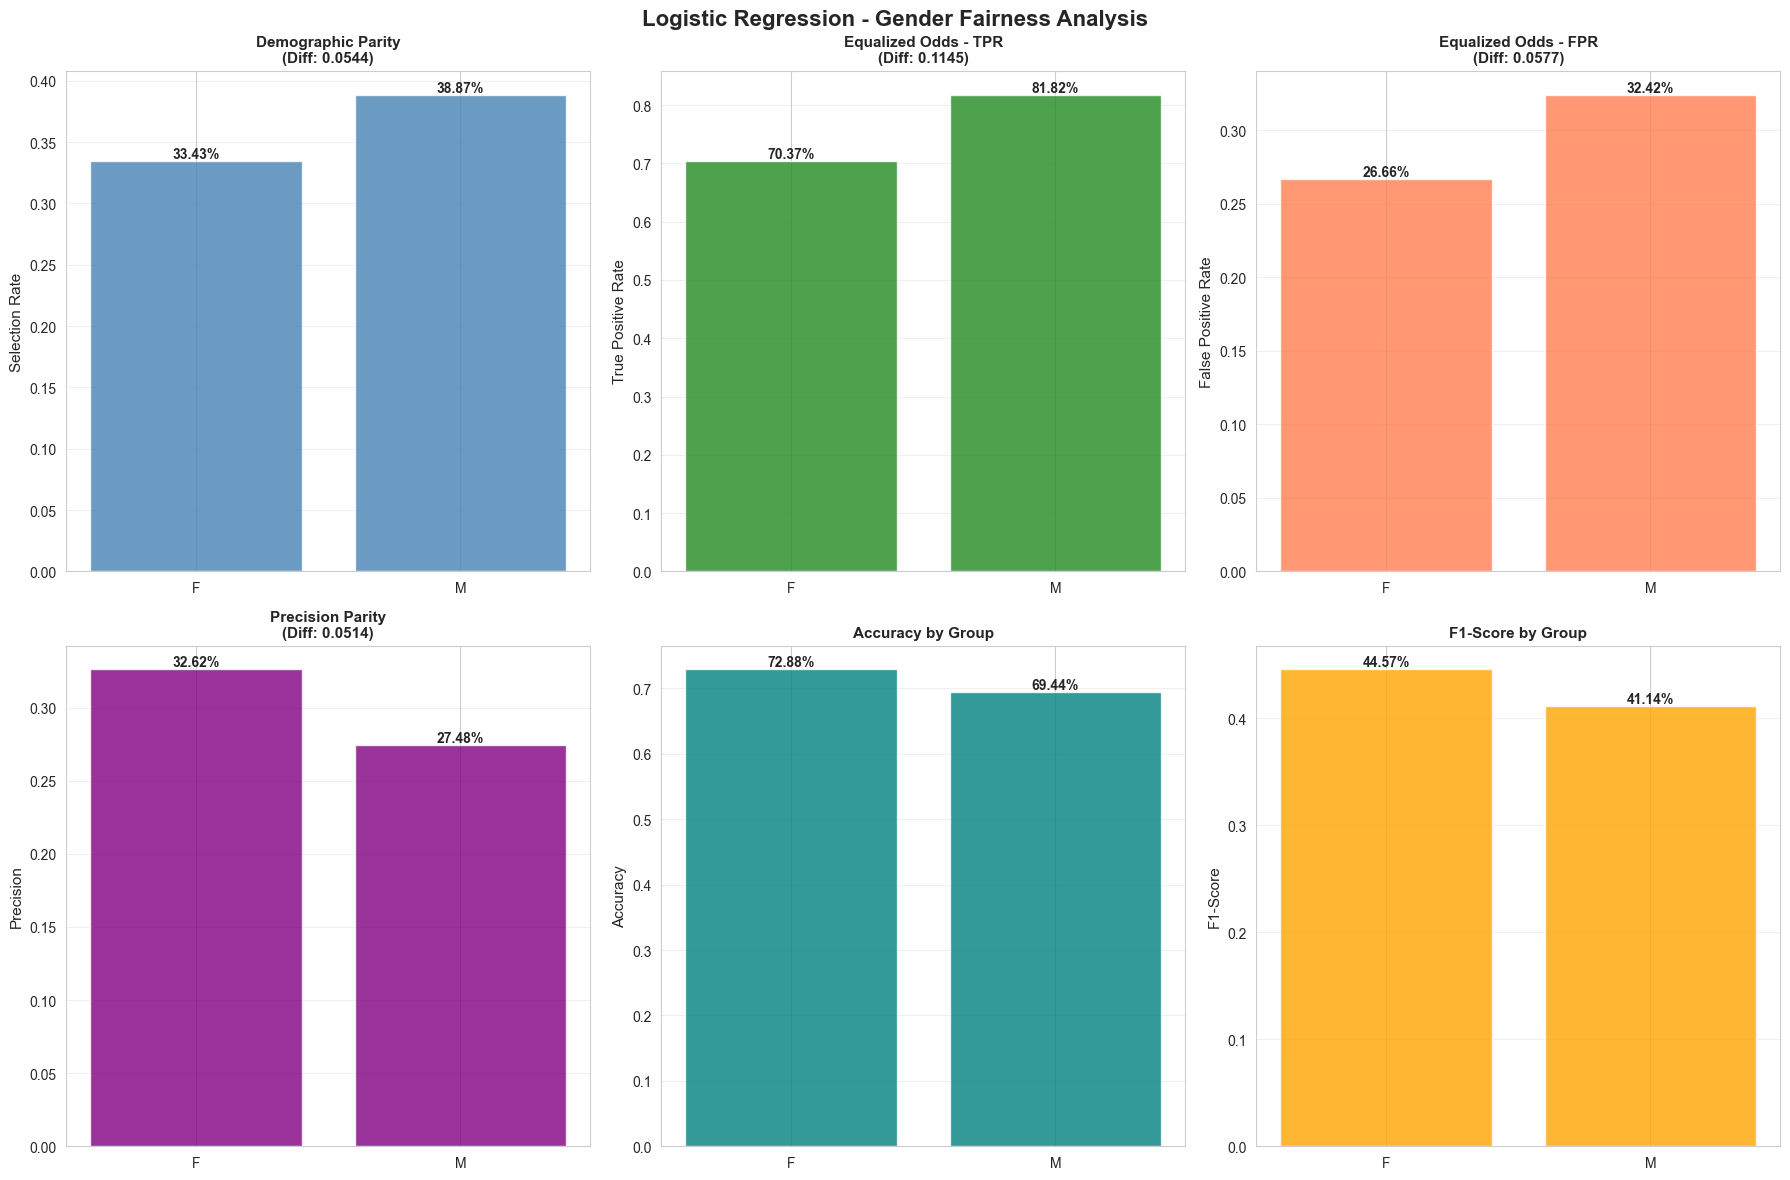


Analyzing protected attribute: EmploymentStatus
   Groups: ['Disabled', 'Employed', 'Medical Leave', 'Retired', 'Unemployed']

   Fairness Metrics:
      Demographic Parity Difference: 0.8609
      Equalized Odds Difference: 0.9038
      Precision Difference: 0.5293
      TPR Difference: 0.4545
      FPR Difference: 0.9038

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Disabled             0.477612   0.227273  0.909091  0.363636             0.607143             0.090909
Employed             0.672454   0.252976  0.726496  0.375276             0.336011             0.273504
Medical Leave        0.607143   0.214286  1.000000  0.352941         

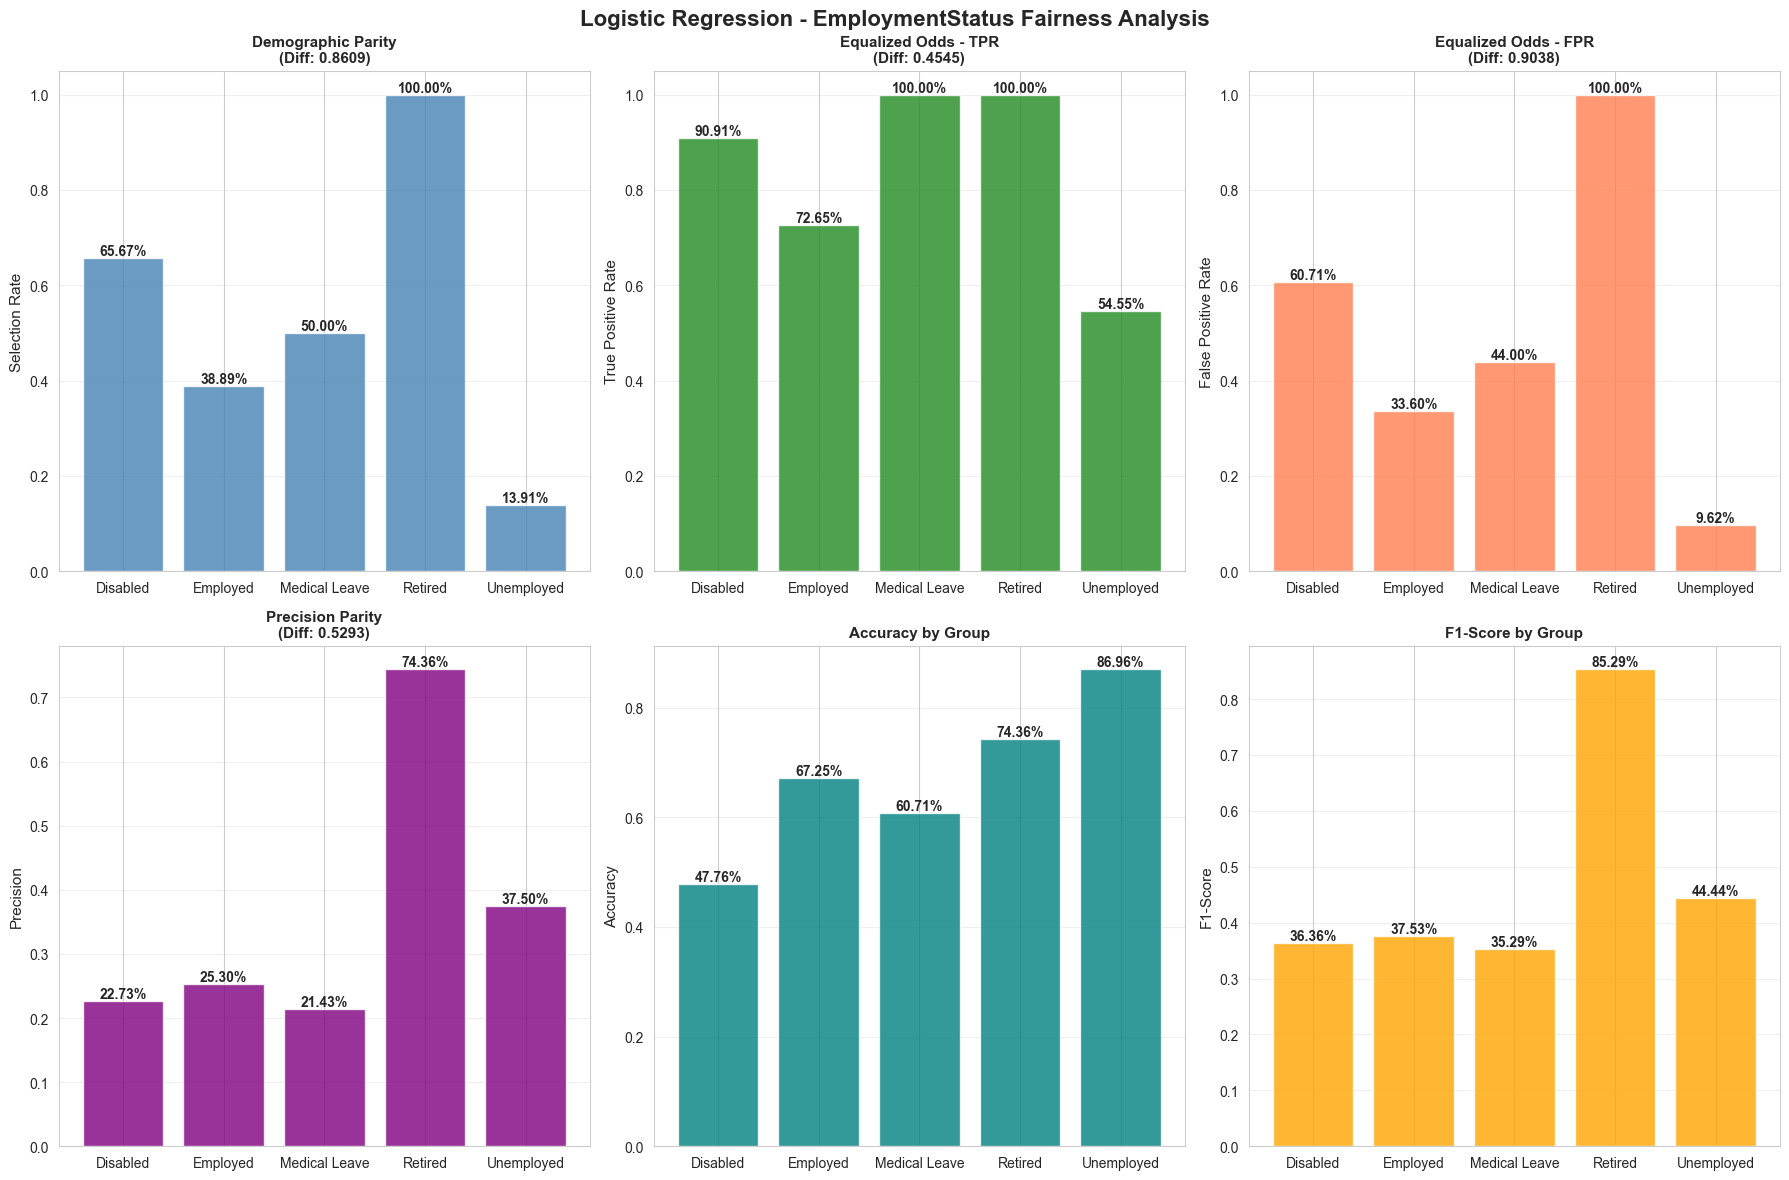


Analyzing protected attribute: Education
   Groups: ['Bachelor', 'College', 'Doctor', 'High School or Below', 'Master']

   Fairness Metrics:
      Demographic Parity Difference: 0.2462
      Equalized Odds Difference: 0.2797
      Precision Difference: 0.2602
      TPR Difference: 0.1554
      FPR Difference: 0.2797

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                      accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                    
Bachelor              0.771117   0.323529  0.687500  0.440000             0.216301             0.312500
College               0.712195   0.355422  0.842857  0.500000             0.314706             0.157143
Doctor                0.771930   0.444444  0.727273  0.551724          

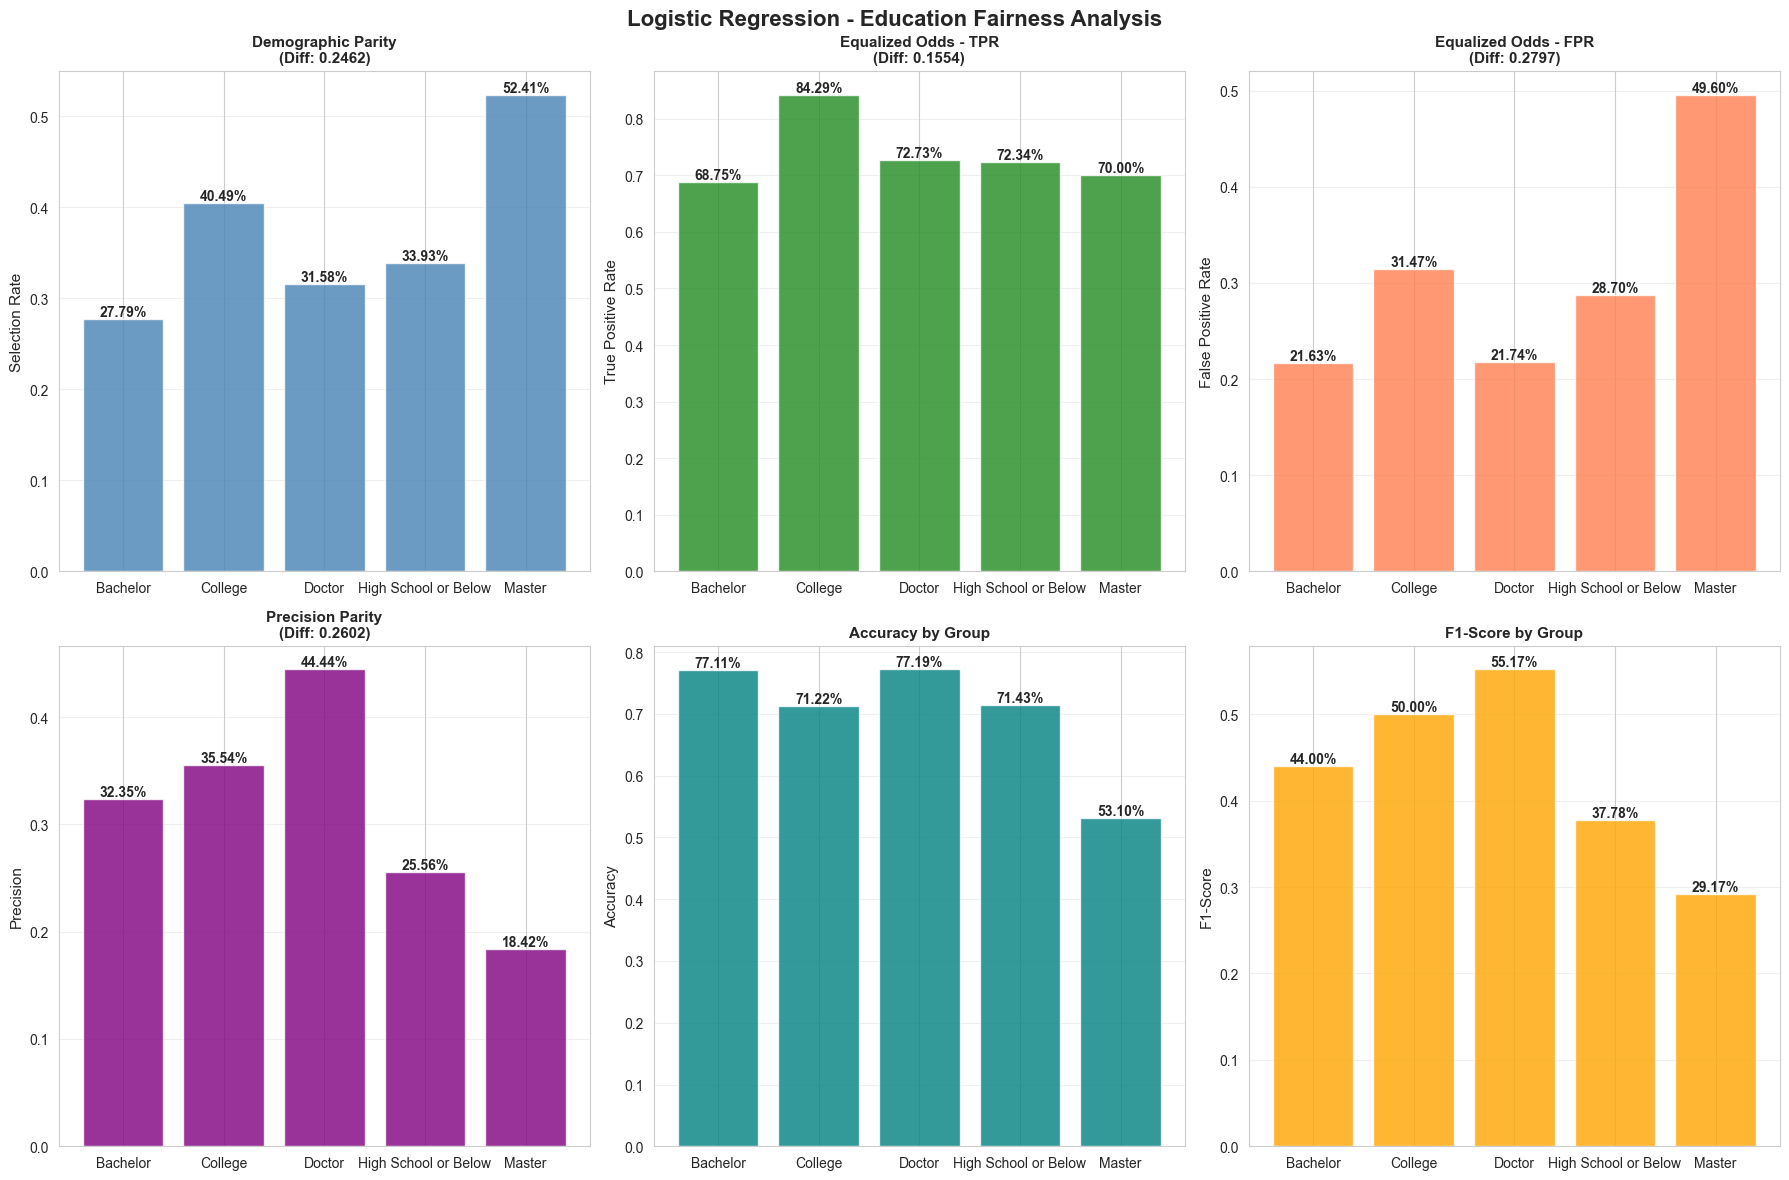


Analyzing protected attribute: Marital Status
   Groups: ['Divorced', 'Married', 'Single']

   Fairness Metrics:
      Demographic Parity Difference: 0.3353
      Equalized Odds Difference: 0.3088
      Precision Difference: 0.1274
      TPR Difference: 0.2300
      FPR Difference: 0.3088

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Divorced             0.597015   0.371901  0.900000  0.526316             0.503311             0.100000
Married              0.698113   0.244526  0.670000  0.358289             0.297842             0.330000
Single               0.802667   0.360000  0.782609  0.493151             0.194529             0.217391


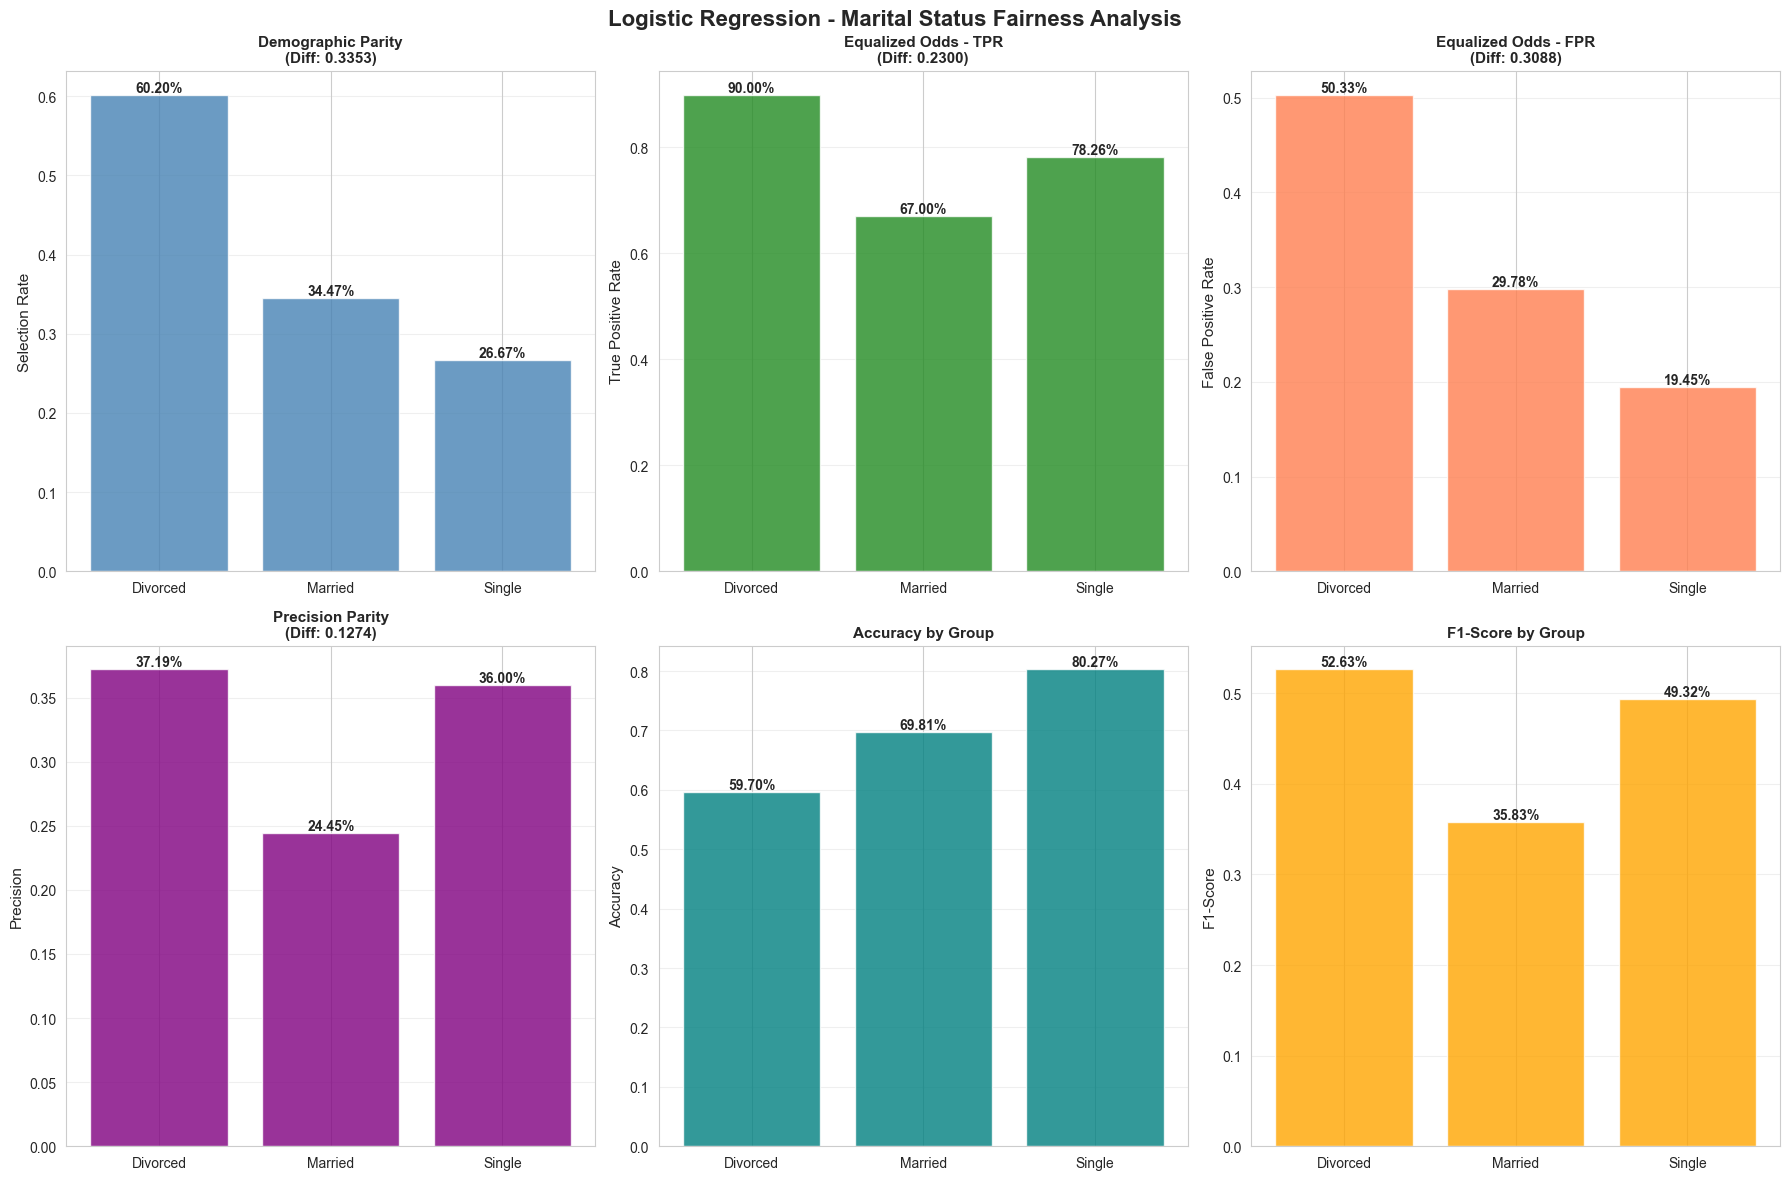


Analyzing protected attribute: Location Code
   Groups: ['Rural', 'Suburban', 'Urban']

   Fairness Metrics:
      Demographic Parity Difference: 0.2593
      Equalized Odds Difference: 0.3589
      Precision Difference: 0.1391
      TPR Difference: 0.3589
      FPR Difference: 0.2070

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Rural                0.794425   0.186441  0.500000  0.271605             0.181132             0.500000
Suburban             0.658625   0.325521  0.838926  0.469043             0.380882             0.161074
Urban                0.792157   0.230769  0.480000  0.311688             0.173913             0.520000


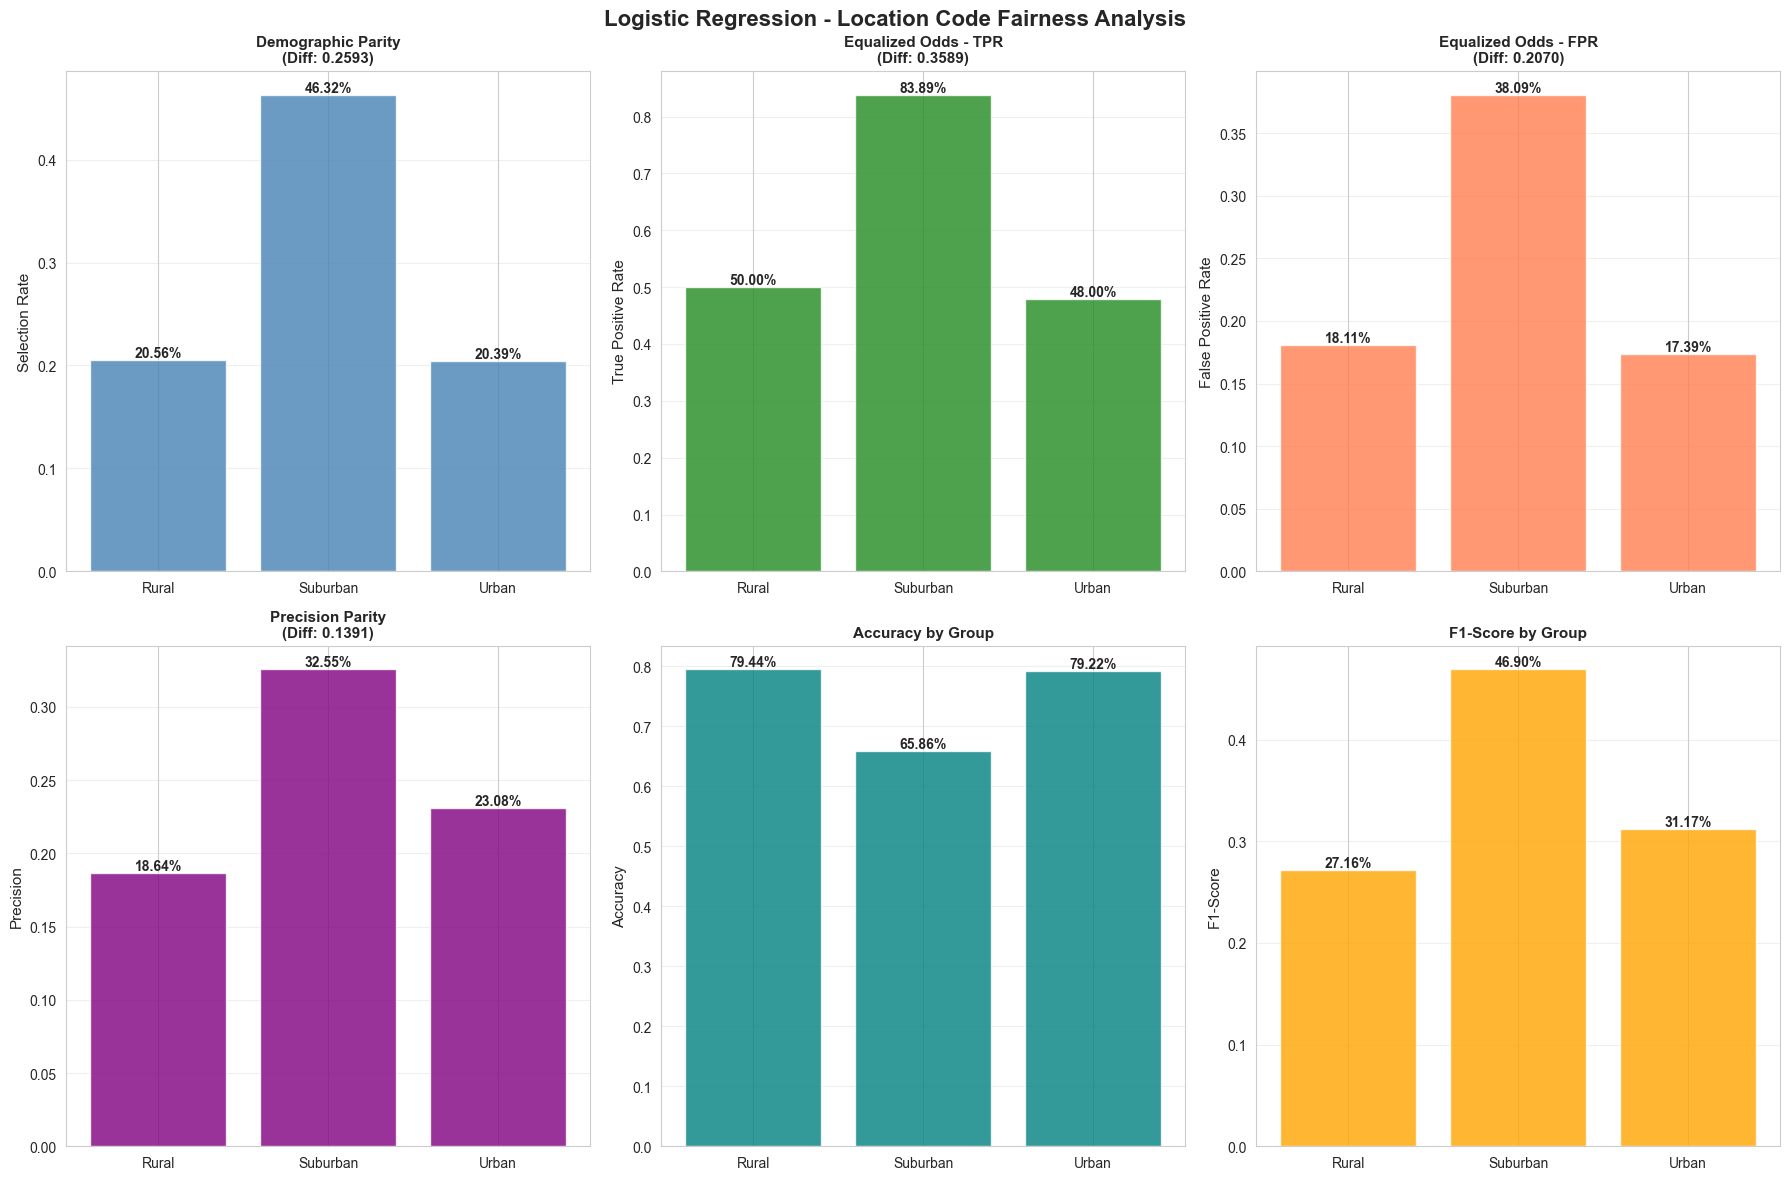


Analyzing protected attribute: State
   Groups: ['Arizona', 'California', 'Nevada', 'Oregon', 'Washington']

   Fairness Metrics:
      Demographic Parity Difference: 0.0729
      Equalized Odds Difference: 0.2078
      Precision Difference: 0.0875
      TPR Difference: 0.2078
      FPR Difference: 0.0702

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Arizona              0.724806   0.314607  0.736842  0.440945             0.277273             0.263158
California           0.720621   0.337500  0.729730  0.461538             0.281167             0.270270
Nevada               0.686567   0.267857  0.937500  0.416667             0.347458      

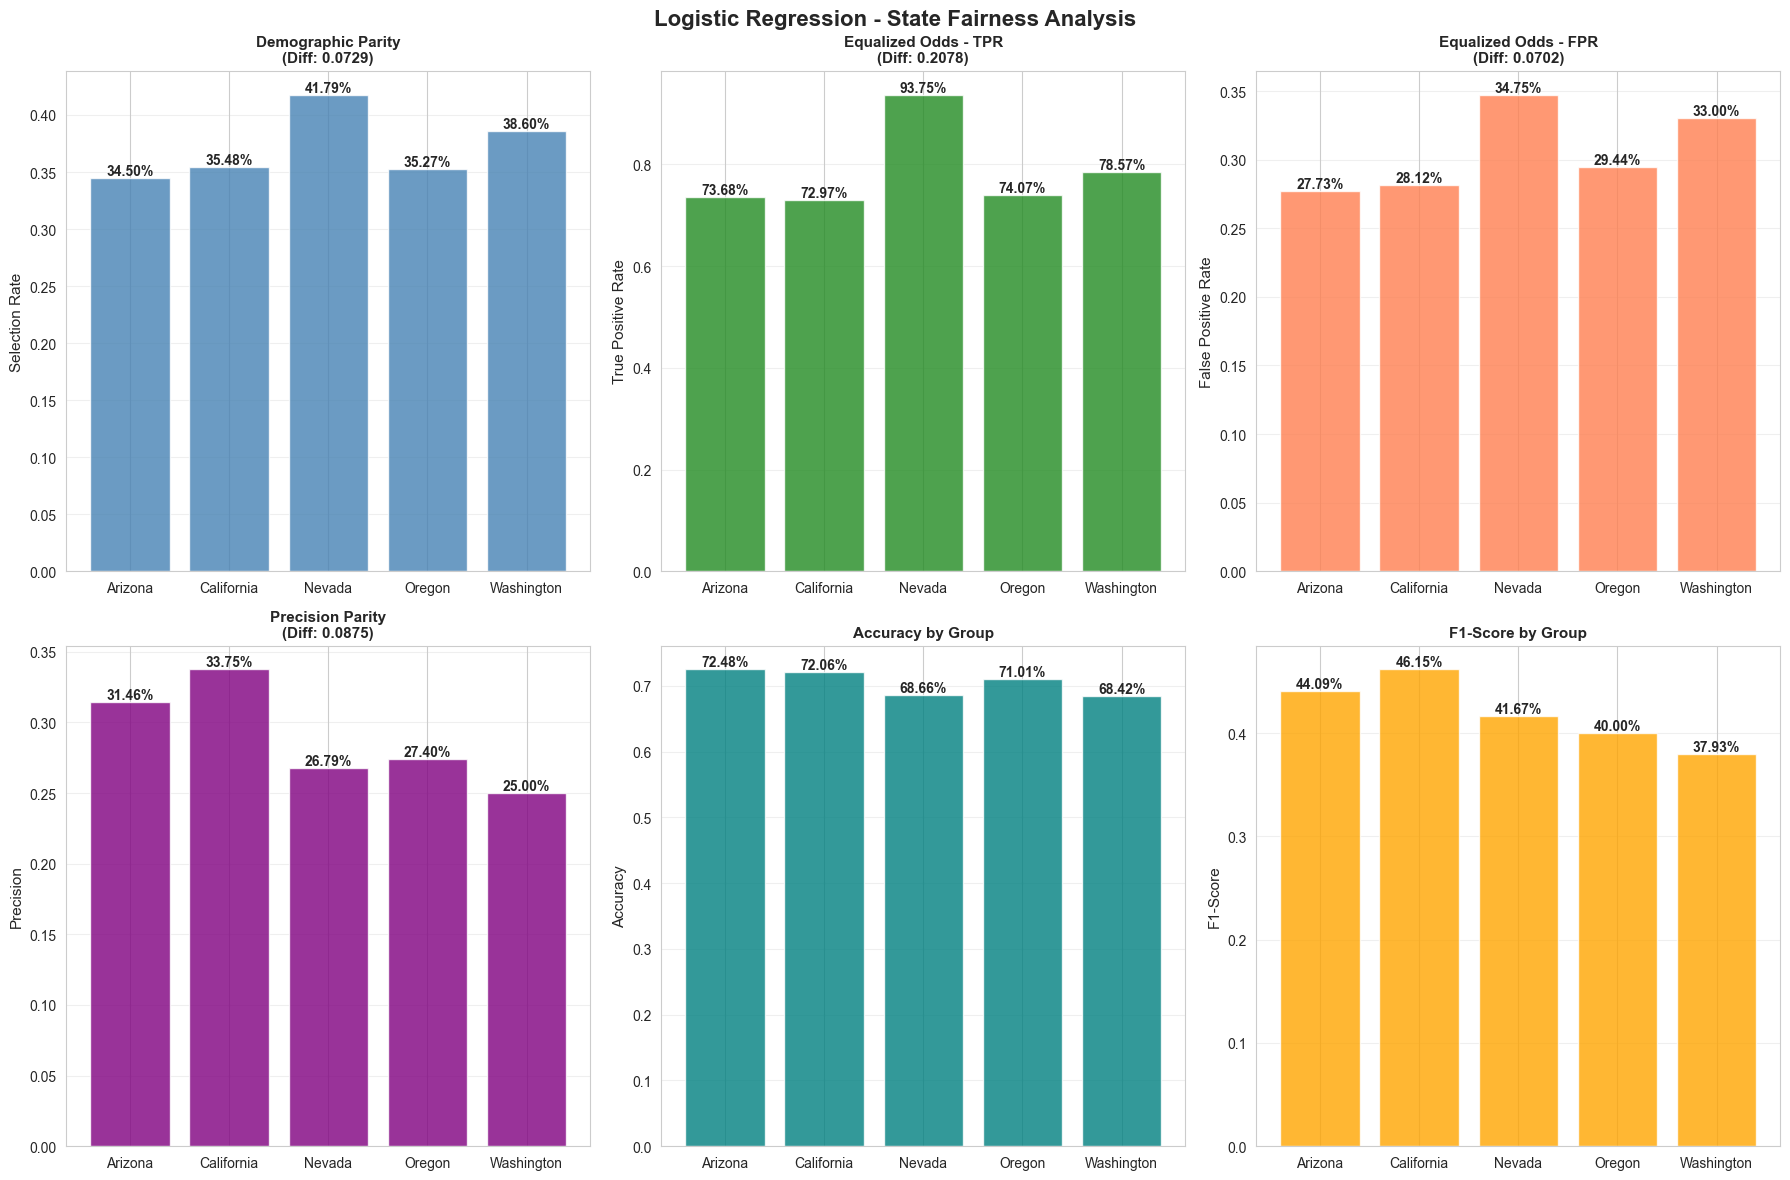


Analyzing protected attribute: Income
   Note: Income is continuous with 971 unique values
   Binning into meaningful categories for fairness analysis...
   Created 6 income groups

Analyzing protected attribute: Income
   Groups: ['$0-$26,540', '$26,540-$40,740', '$40,740-$59,207', '$59,207-$76,514', '$76,514+', 'Zero Income']

   Fairness Metrics:
      Demographic Parity Difference: 0.4725
      Equalized Odds Difference: 0.4165
      Precision Difference: 0.1773
      TPR Difference: 0.3920
      FPR Difference: 0.4165

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
$0-$26,540           0.592233   0.357143  0.937500  0.517241           

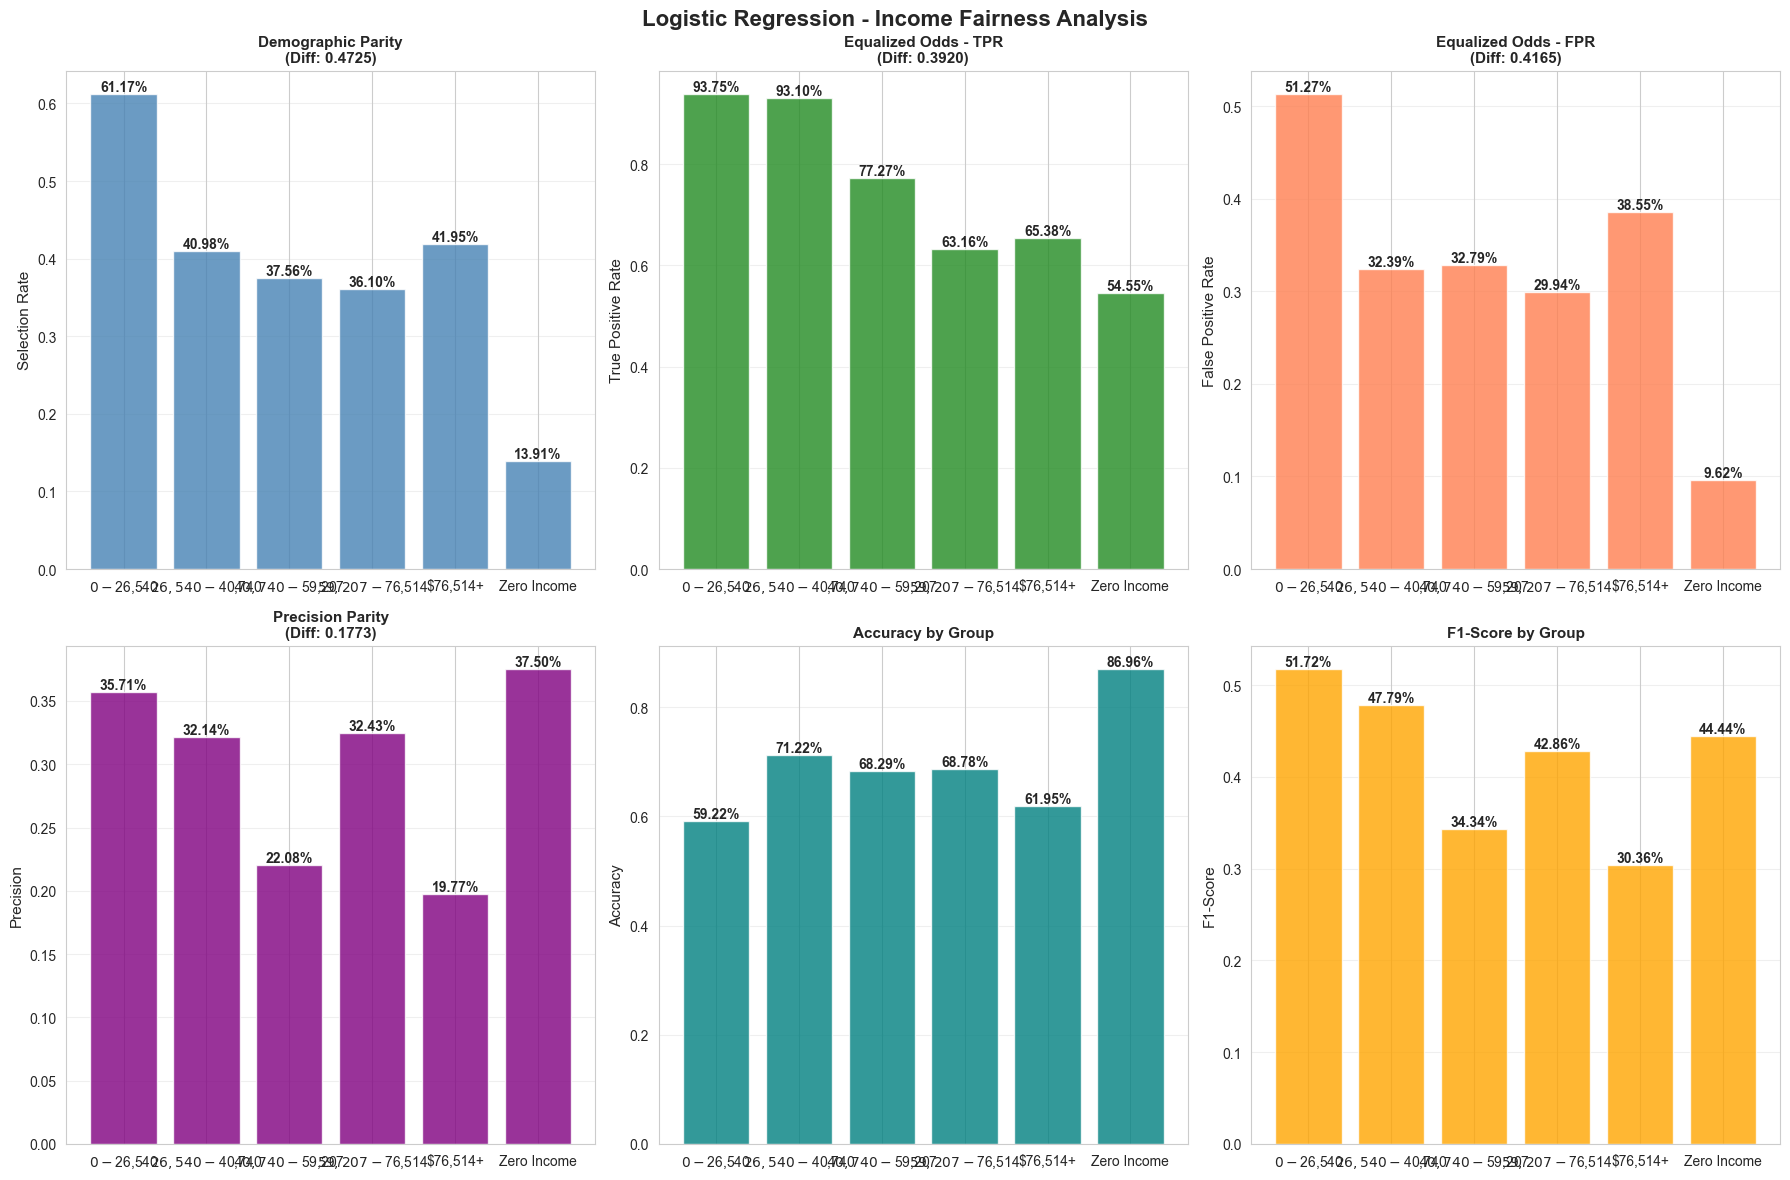


Analyzing: Random Forest

Analyzing protected attribute: Gender
   Groups: ['F', 'M']

   Fairness Metrics:
      Demographic Parity Difference: 0.0289
      Equalized Odds Difference: 0.0097
      Precision Difference: 0.0210
      TPR Difference: 0.0093
      FPR Difference: 0.0097

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
F                    0.912482   0.640719  0.990741  0.778182             0.101868             0.009259
M                    0.919881   0.619718  1.000000  0.765217             0.092150             0.000000


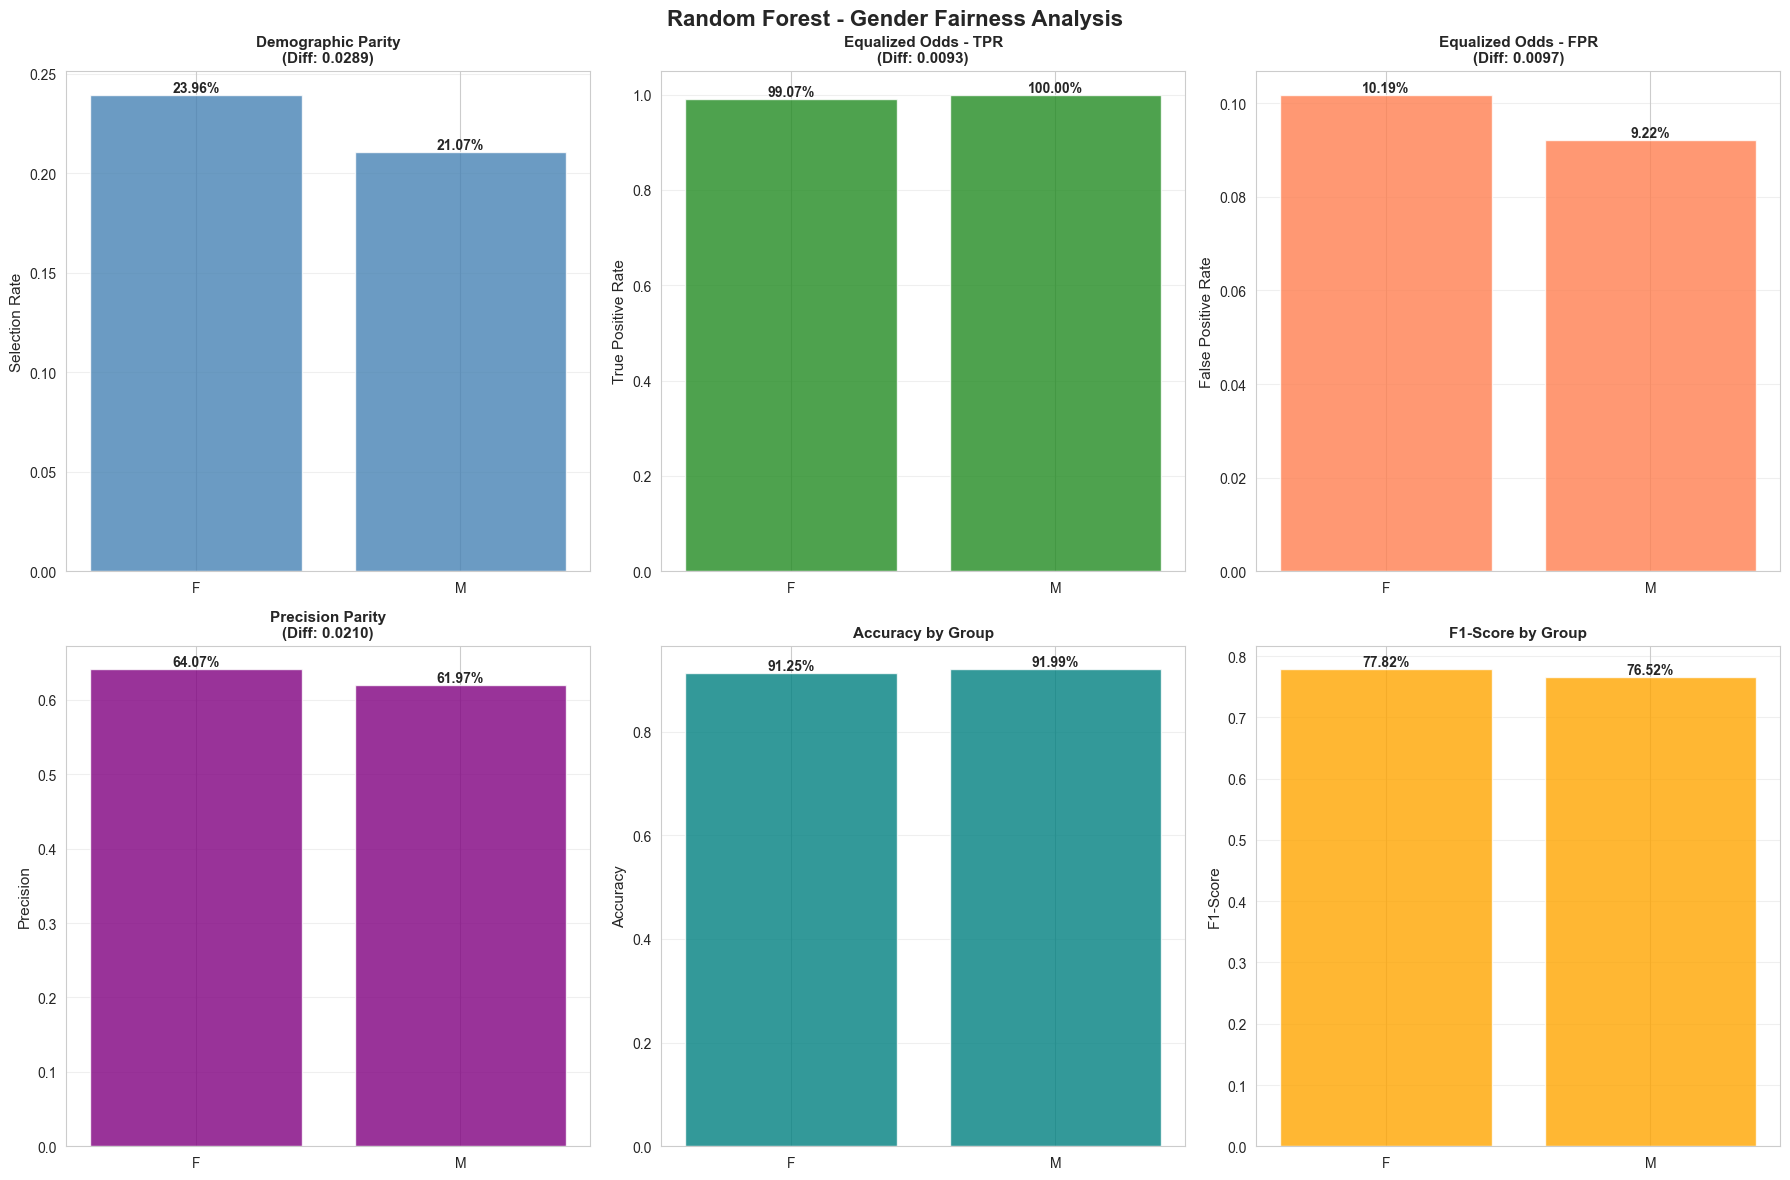


Analyzing protected attribute: EmploymentStatus
   Groups: ['Disabled', 'Employed', 'Medical Leave', 'Retired', 'Unemployed']

   Fairness Metrics:
      Demographic Parity Difference: 0.7989
      Equalized Odds Difference: 0.5936
      Precision Difference: 0.5745
      TPR Difference: 0.0303
      FPR Difference: 0.5936

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Disabled             0.716418   0.366667  1.000000  0.536585             0.339286             0.000000
Employed             0.910880   0.603093  1.000000  0.752412             0.103079             0.000000
Medical Leave        0.821429   0.375000  1.000000  0.545455         

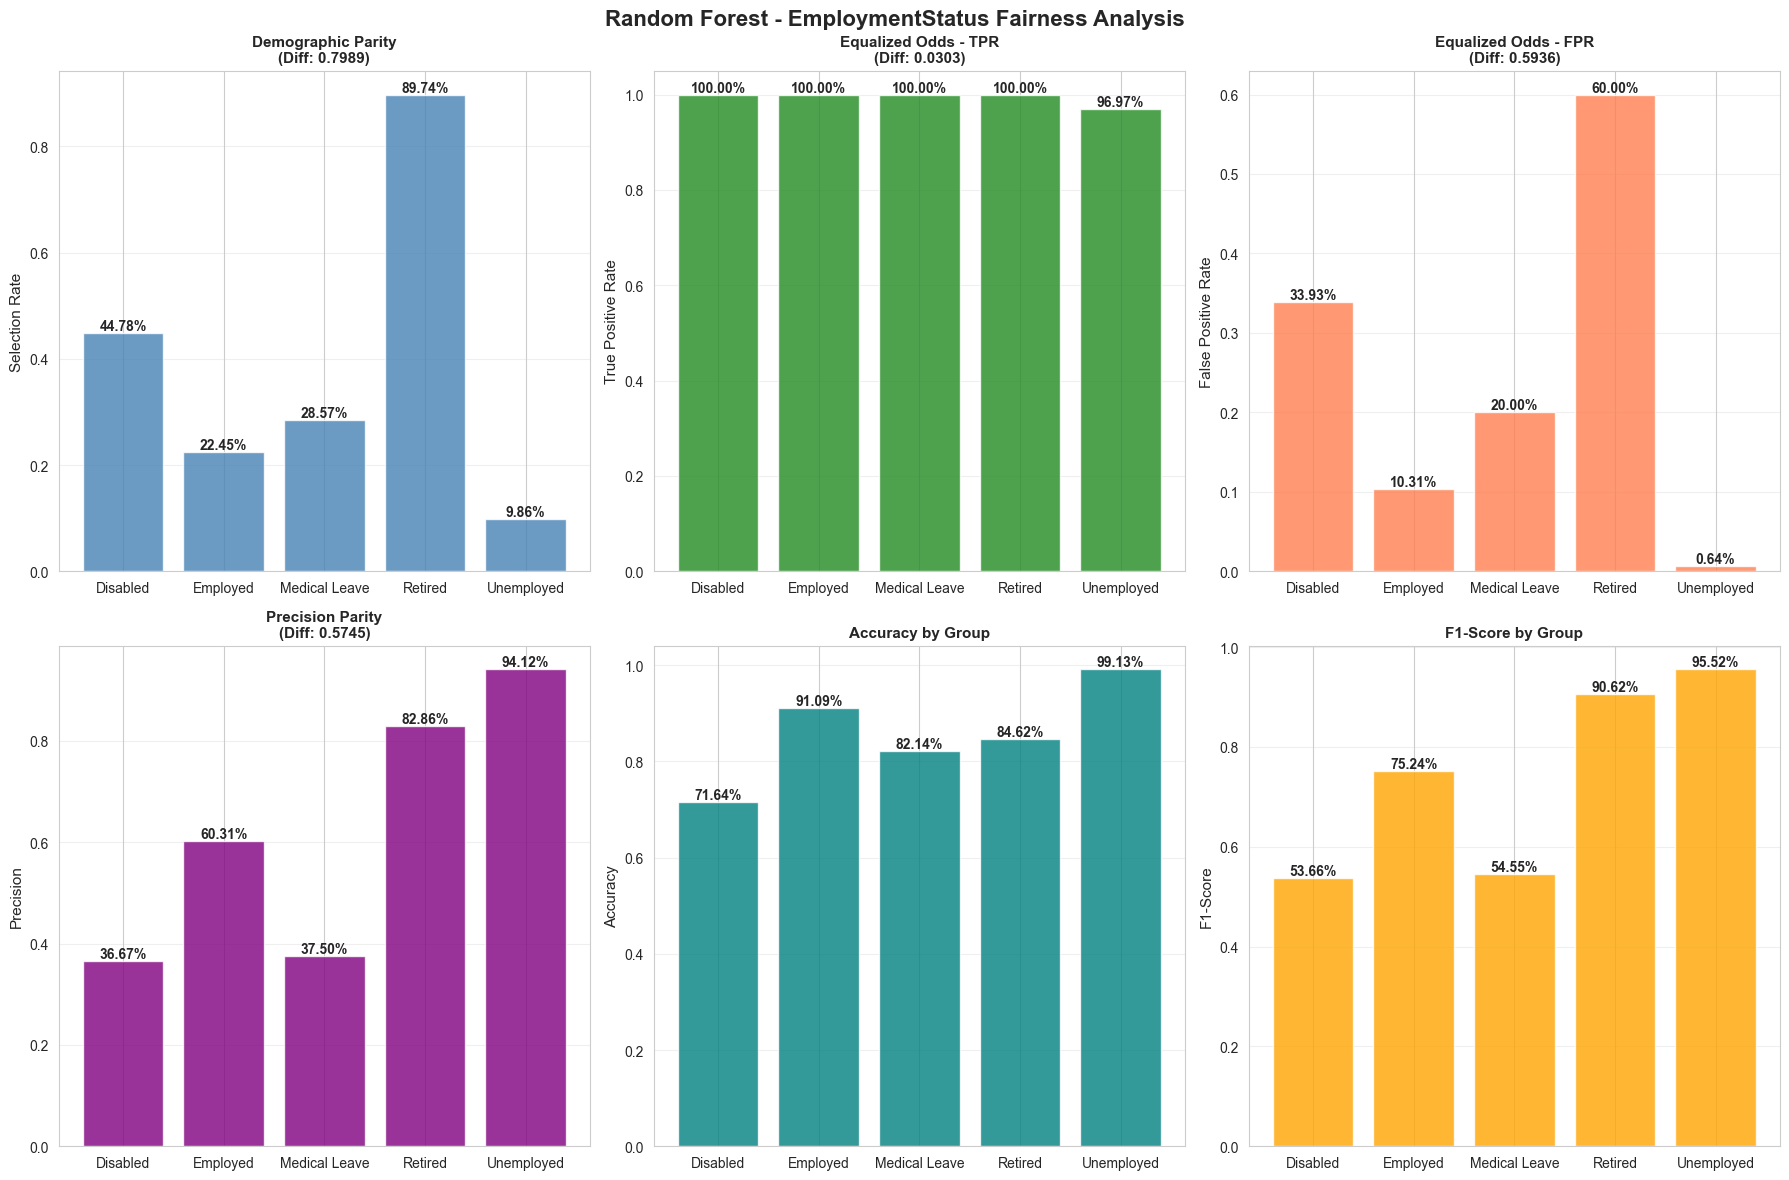


Analyzing protected attribute: Education
   Groups: ['Bachelor', 'College', 'Doctor', 'High School or Below', 'Master']

   Fairness Metrics:
      Demographic Parity Difference: 0.0876
      Equalized Odds Difference: 0.1265
      Precision Difference: 0.4659
      TPR Difference: 0.0500
      FPR Difference: 0.1265

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                      accuracy  precision  recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                  
Bachelor              0.942779   0.695652    1.00  0.820513             0.065831                 0.00
College               0.895122   0.619469    1.00  0.765027             0.126471                 0.00
Doctor                1.000000   1.000000    1.00  1.000000             0.00000

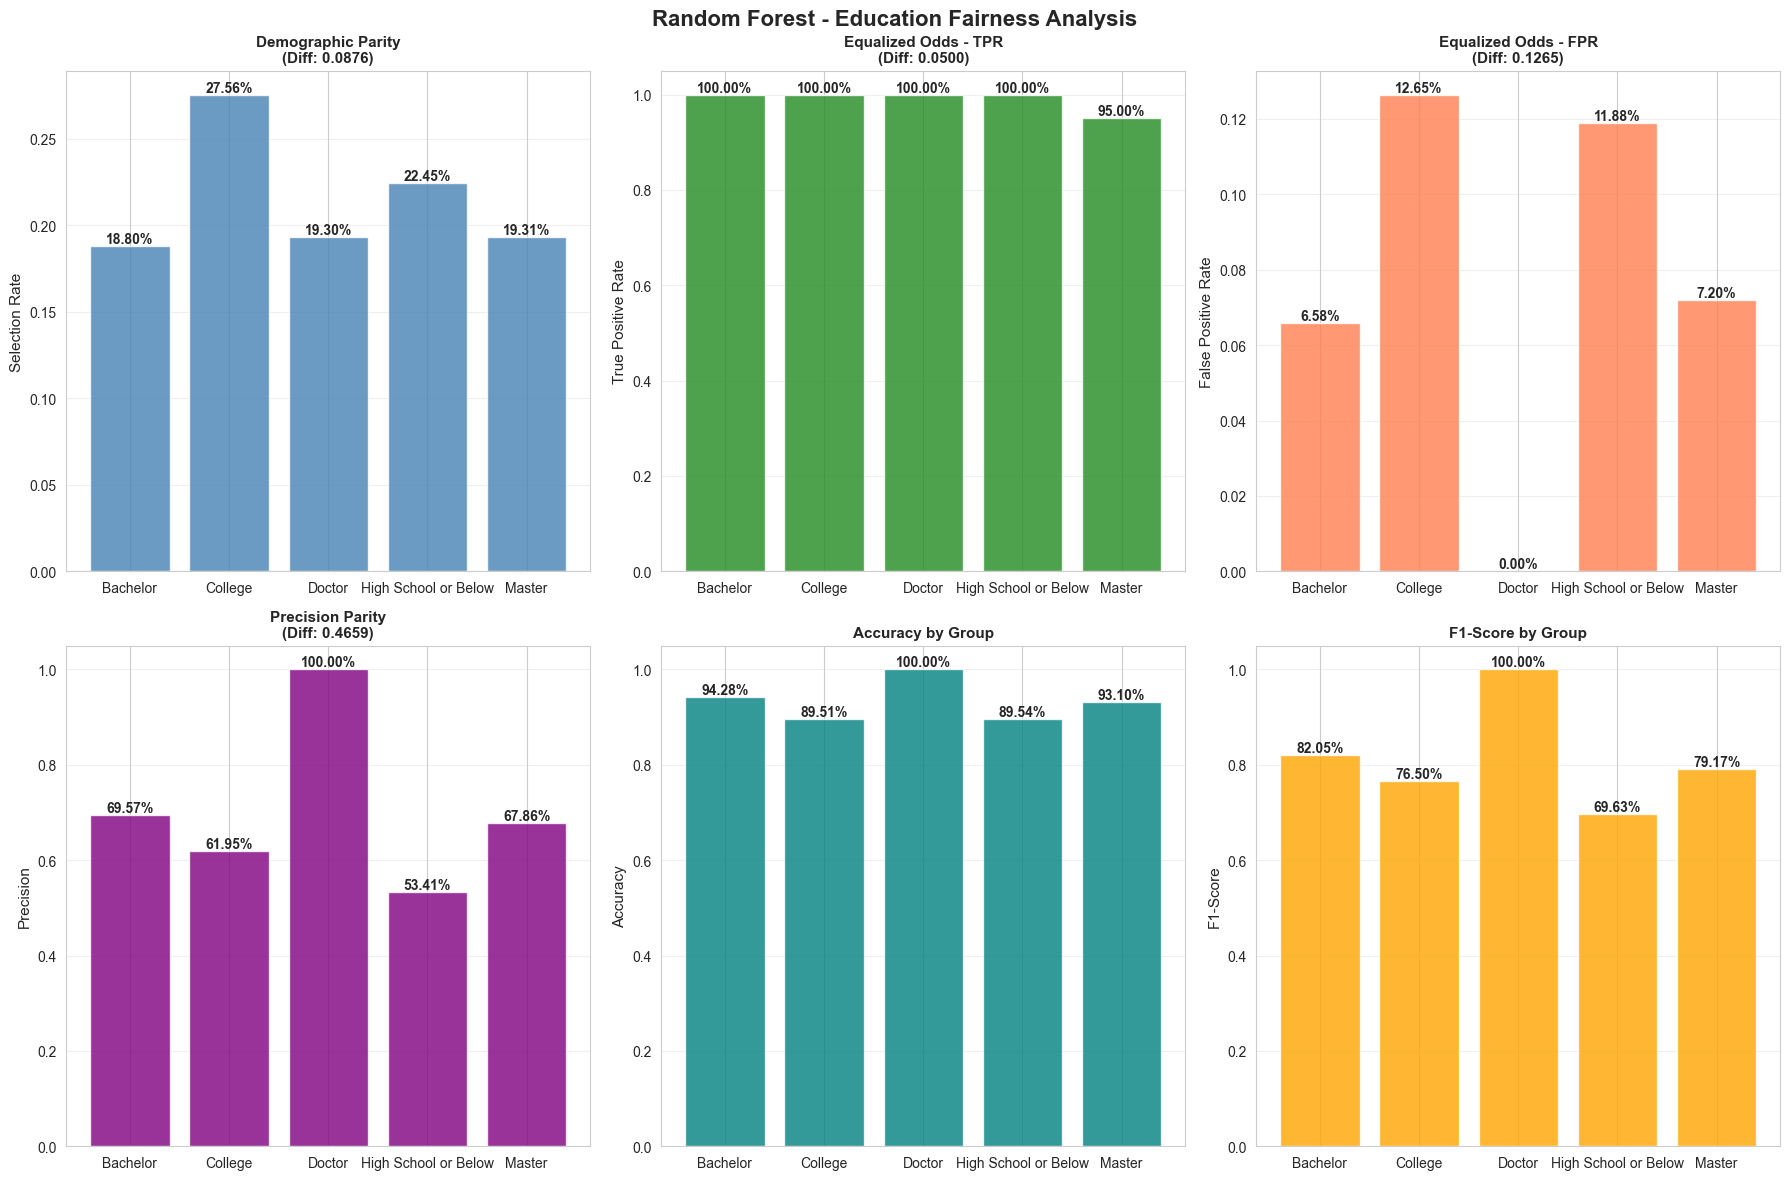


Analyzing protected attribute: Marital Status
   Groups: ['Divorced', 'Married', 'Single']

   Fairness Metrics:
      Demographic Parity Difference: 0.1906
      Equalized Odds Difference: 0.0904
      Precision Difference: 0.1727
      TPR Difference: 0.0217
      FPR Difference: 0.0904

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Divorced             0.895522   0.704225  1.000000  0.826446             0.139073             0.000000
Married              0.903145   0.564972  1.000000  0.722022             0.110791             0.000000
Single               0.954667   0.737705  0.978261  0.841121             0.048632             0.021739


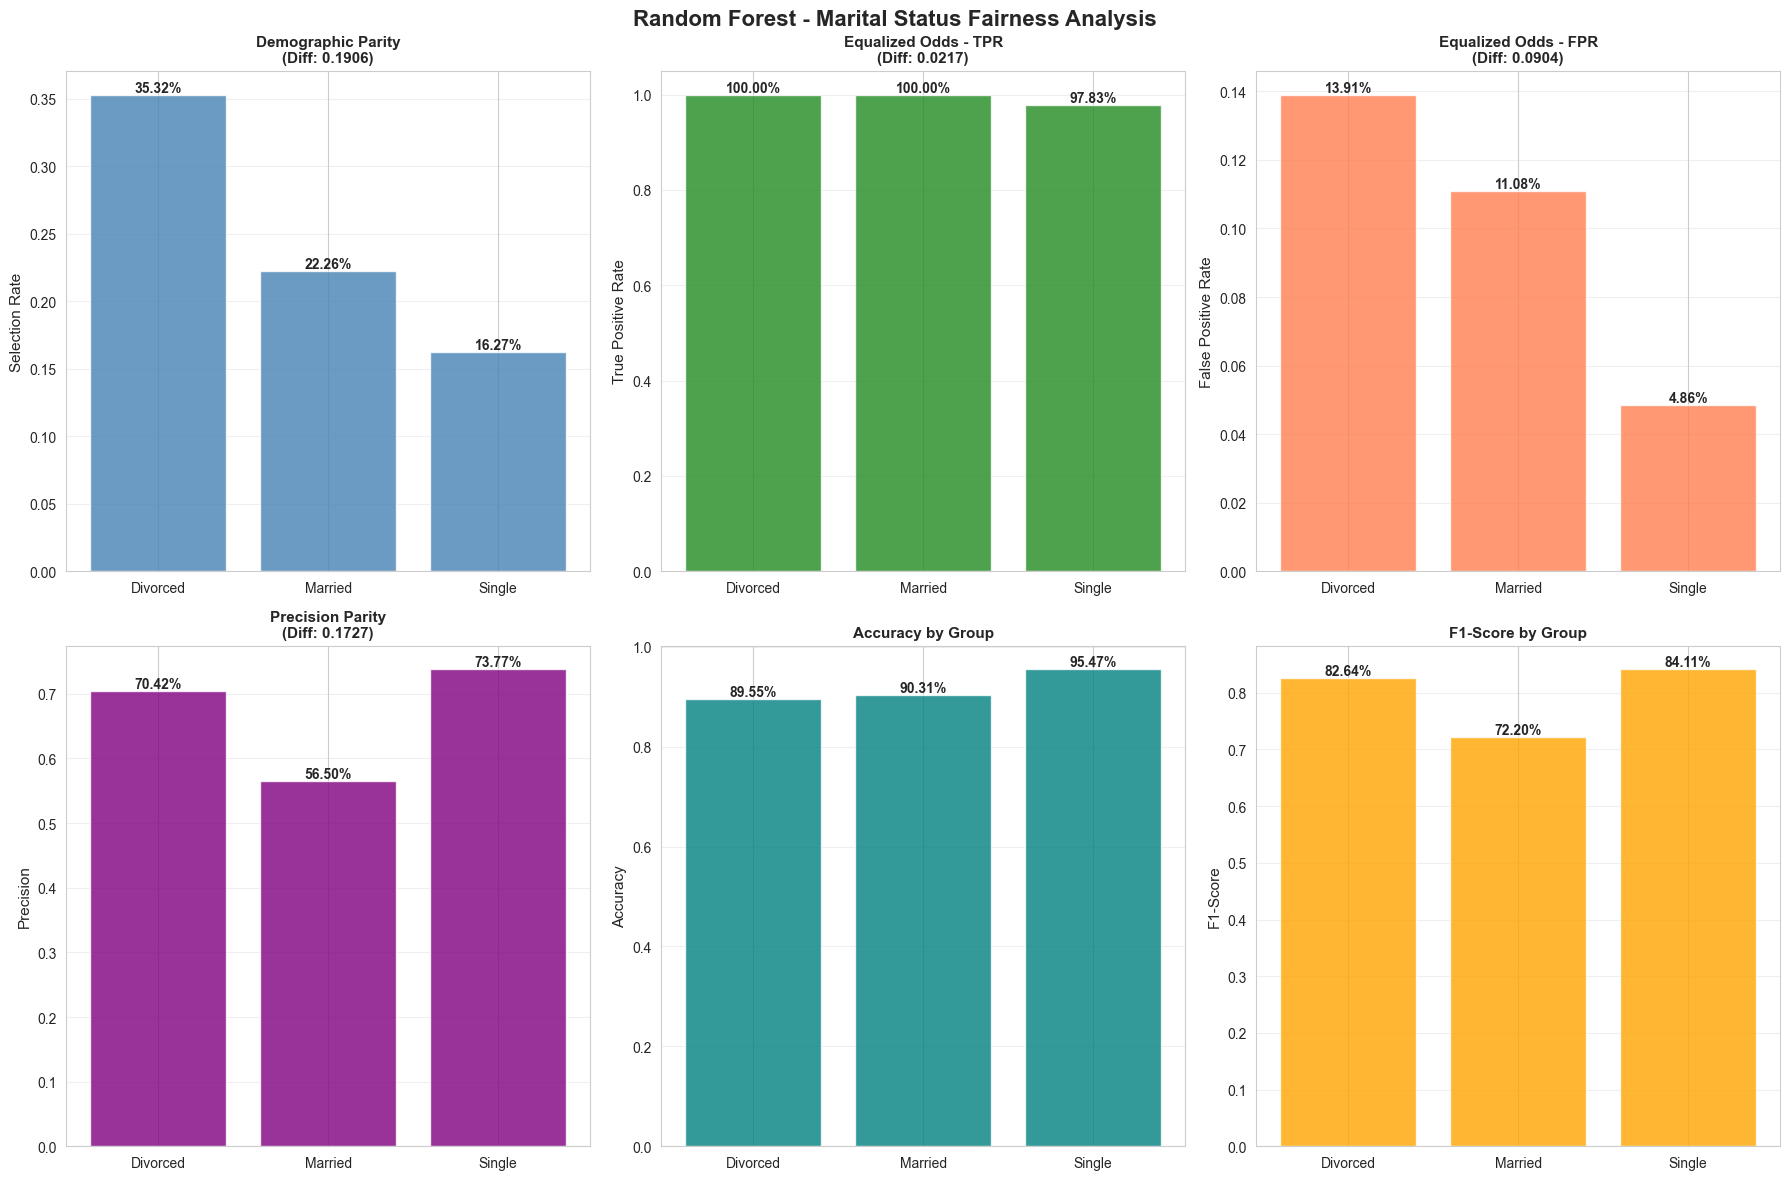


Analyzing protected attribute: Location Code
   Groups: ['Rural', 'Suburban', 'Urban']

   Fairness Metrics:
      Demographic Parity Difference: 0.2217
      Equalized Odds Difference: 0.1475
      Precision Difference: 0.3147
      TPR Difference: 0.0067
      FPR Difference: 0.1475

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Rural                0.989547   0.880000  1.000000  0.936170             0.011321             0.000000
Suburban             0.868516   0.578125  0.993289  0.730864             0.158824             0.006711
Urban                0.988235   0.892857  1.000000  0.943396             0.013043             0.000000


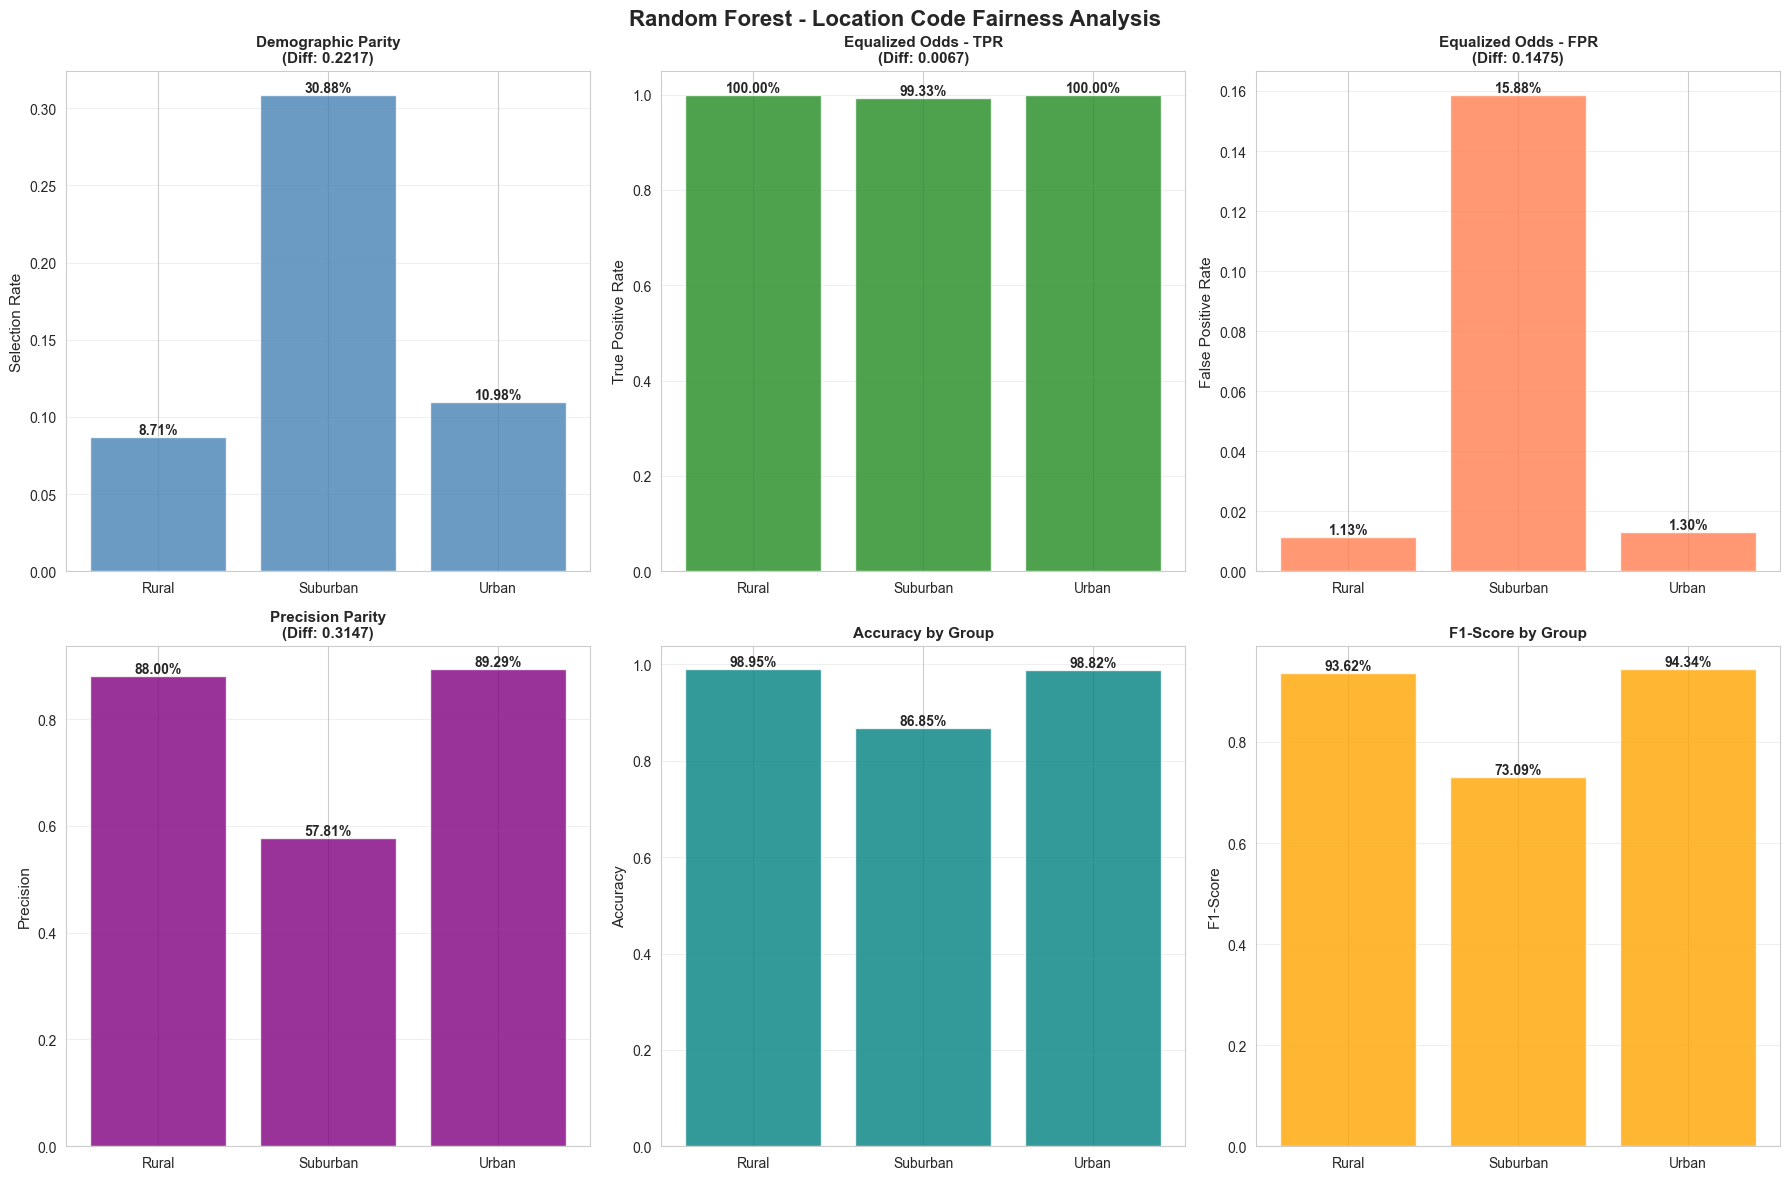


Analyzing protected attribute: State
   Groups: ['Arizona', 'California', 'Nevada', 'Oregon', 'Washington']

   Fairness Metrics:
      Demographic Parity Difference: 0.0261
      Equalized Odds Difference: 0.0225
      Precision Difference: 0.1287
      TPR Difference: 0.0135
      FPR Difference: 0.0225

   [WARNING] Significant disparities detected:
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
Arizona              0.918605   0.644068  1.000000  0.783505             0.095455             0.000000
California           0.924612   0.688679  0.986486  0.811111             0.087533             0.013514
Nevada               0.910448   0.571429  1.000000  0.727273             0.101695             0.000000
Oregon               0.910628   0.593407  1.000000  0.744828      

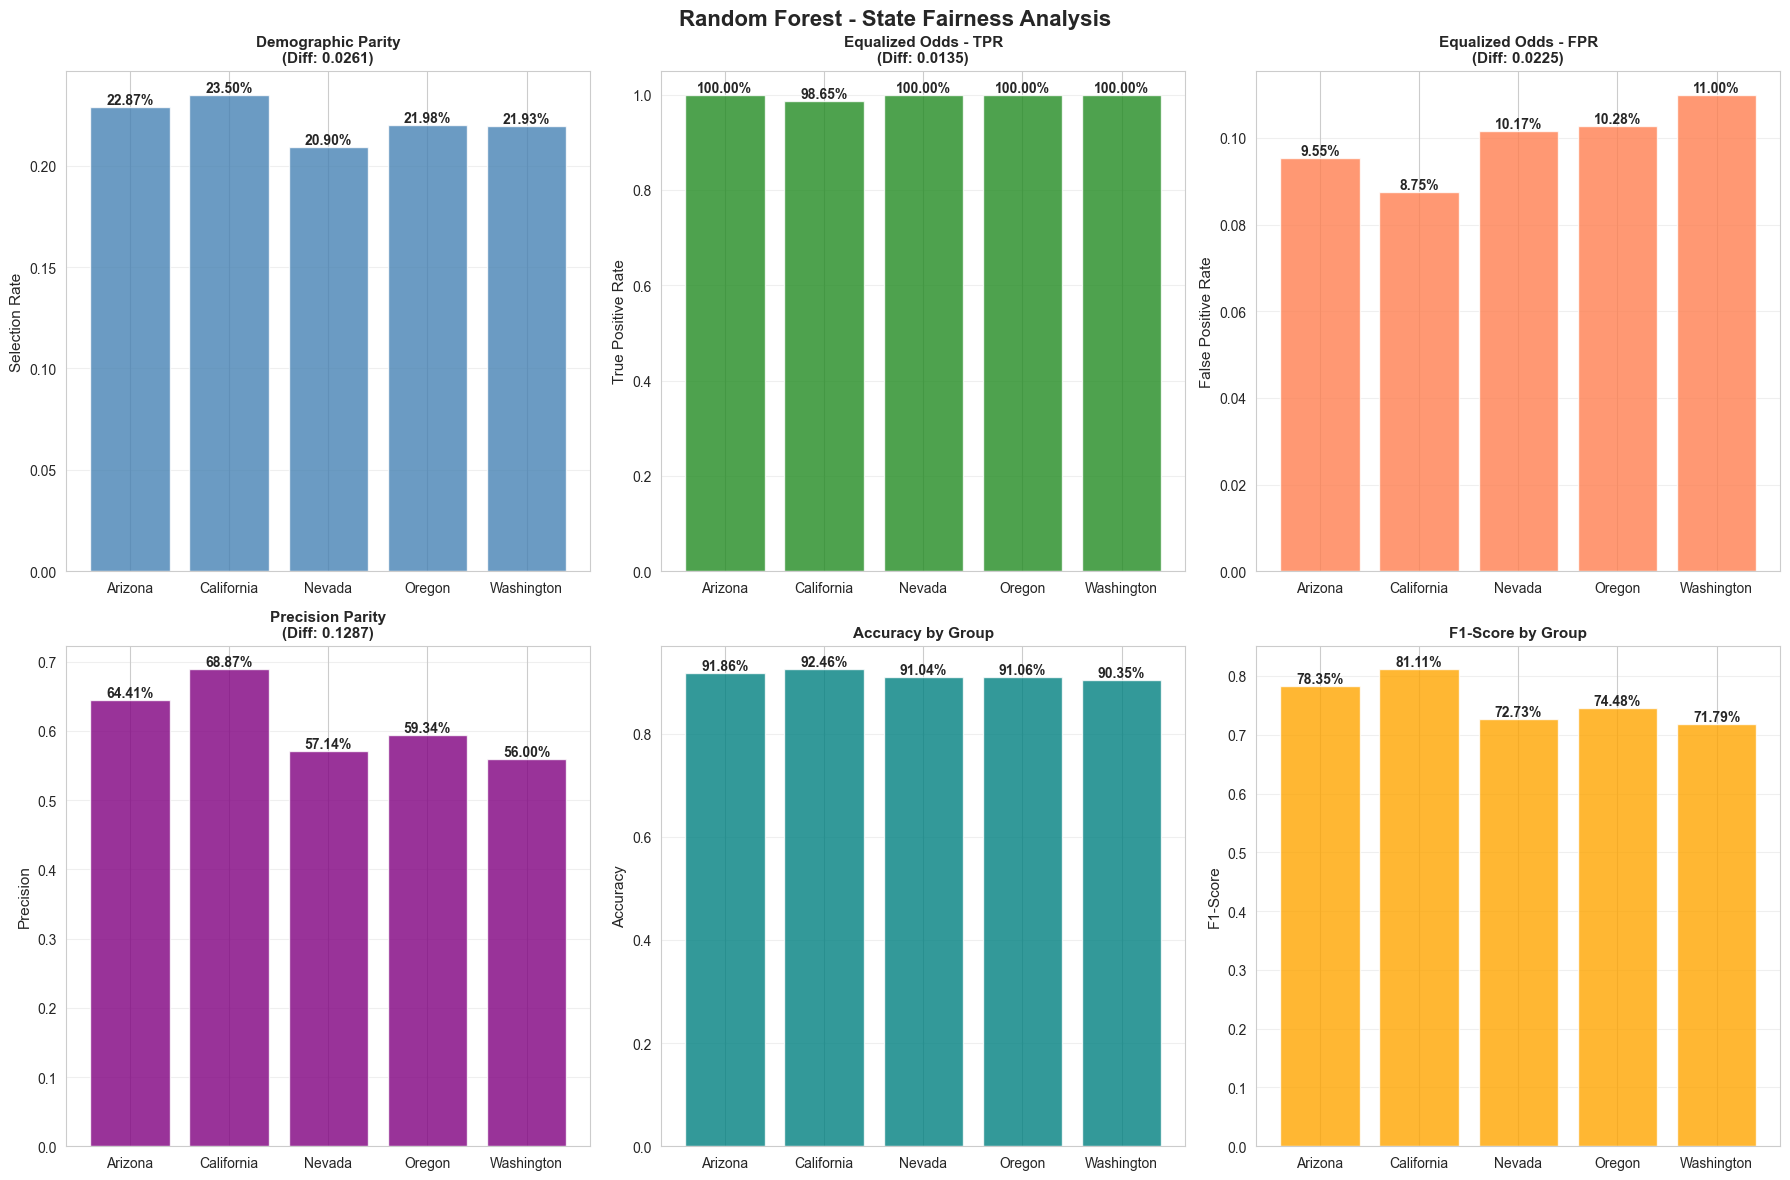


Analyzing protected attribute: Income
   Note: Income is continuous with 971 unique values
   Binning into meaningful categories for fairness analysis...
   Created 6 income groups

Analyzing protected attribute: Income
   Groups: ['$0-$26,540', '$26,540-$40,740', '$40,740-$59,207', '$59,207-$76,514', '$76,514+', 'Zero Income']

   Fairness Metrics:
      Demographic Parity Difference: 0.3189
      Equalized Odds Difference: 0.2341
      Precision Difference: 0.4412
      TPR Difference: 0.0303
      FPR Difference: 0.2341

   [WARNING] Significant disparities detected:
      • Demographic parity disparity > 5pp
      • Equalized odds disparity > 5pp
      • Precision disparity > 5pp

   Group-Level Performance:
                     accuracy  precision    recall        f1  false_positive_rate  false_negative_rate
sensitive_feature_0                                                                                   
$0-$26,540           0.815534   0.558140  1.000000  0.716418           

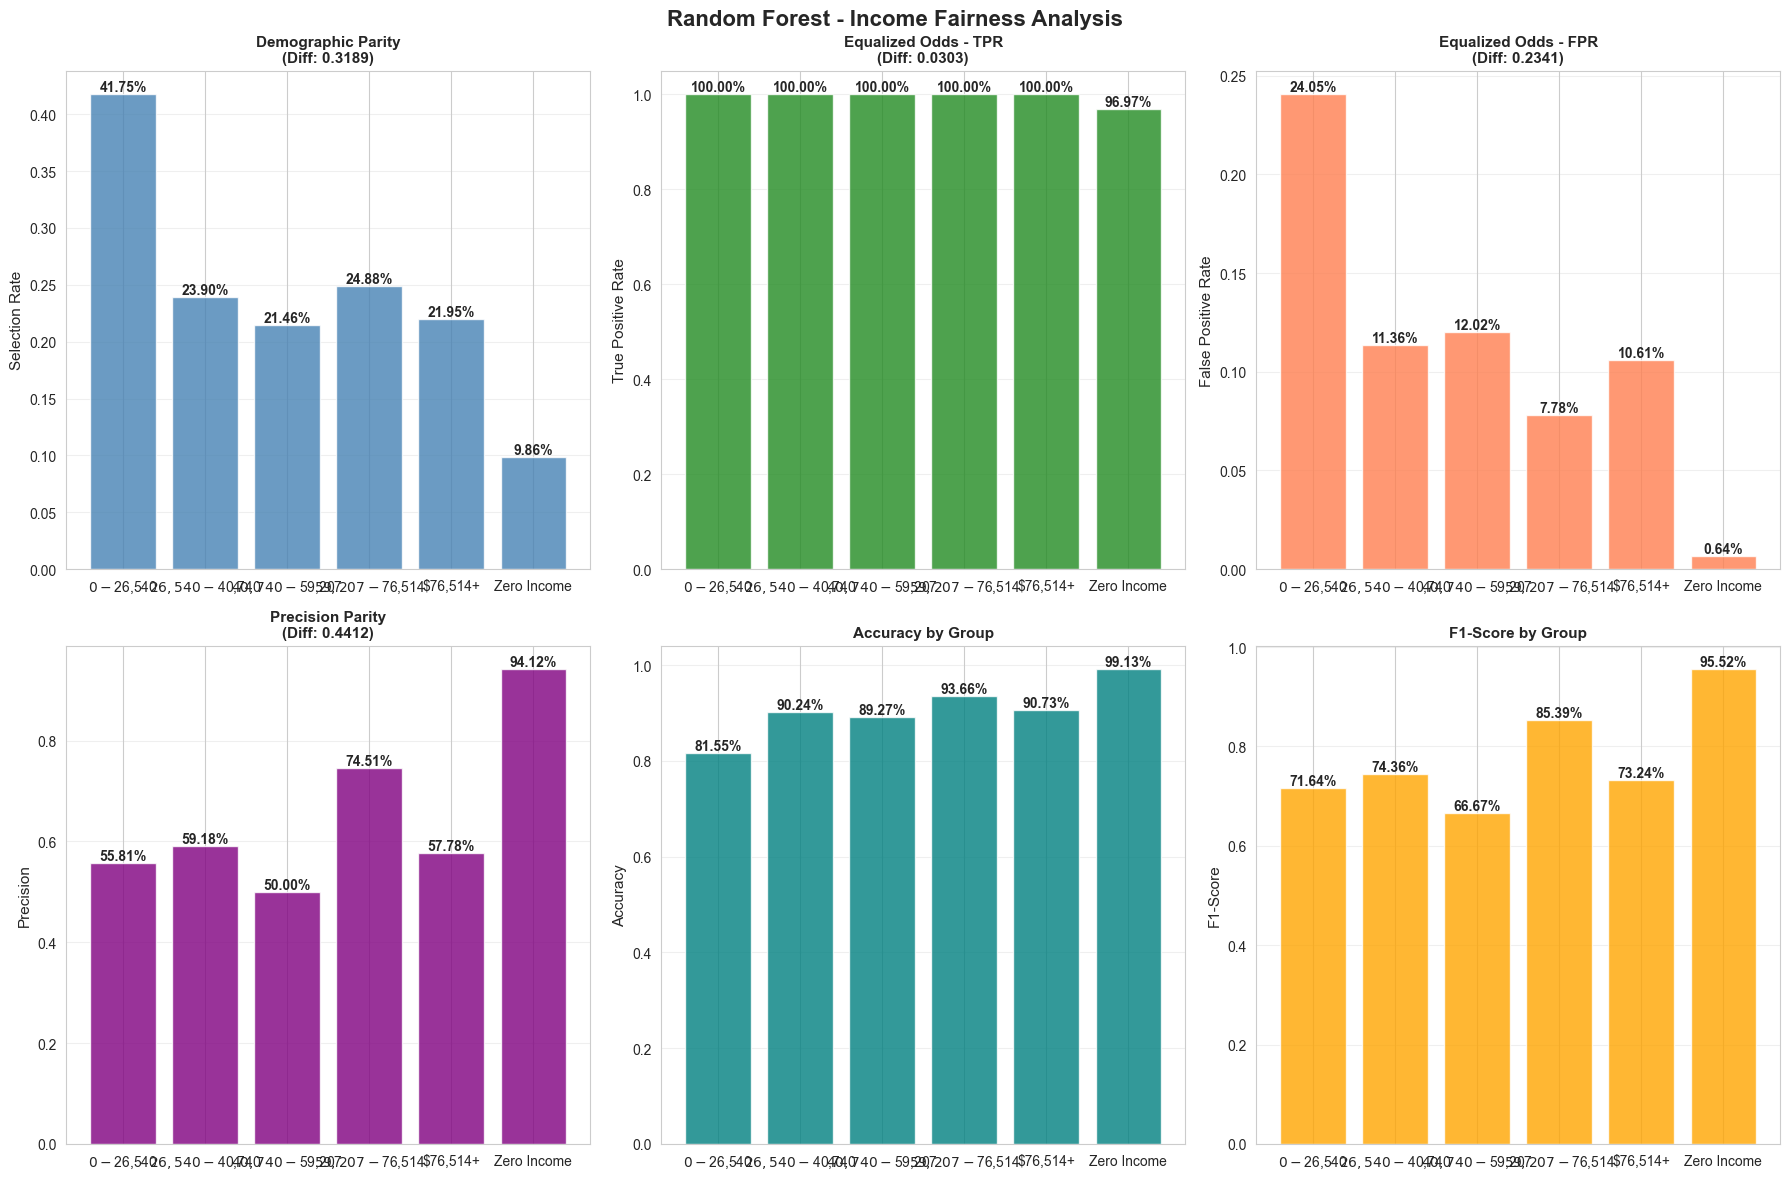


COMPREHENSIVE ANALYSIS COMPLETE


In [8]:
# Store all fairness results
all_fairness_results = {}

# Models to analyze
models = {
    'Logistic Regression': (lr_test_pred, lr_test_proba),
    'Random Forest': (rf_test_pred, rf_test_proba)
}

print("=" * 60)
print("COMPREHENSIVE FAIRNESS ANALYSIS")
print("=" * 60)

# Analyze each model and each protected attribute
for model_name, (y_pred, y_proba) in models.items():
    print(f"\n{'='*60}")
    print(f"Analyzing: {model_name}")
    print(f"{'='*60}")
    
    all_fairness_results[model_name] = {}
    
    for attr in protected_attributes_list:
        if attr not in protected_test.columns:
            print(f"Warning: {attr} not found in protected_test, skipping...")
            continue
            
        sensitive_feature = protected_test[attr]
        
        # Special handling for Income: bin continuous values into categories
        if attr == 'Income':
            # Check if Income is continuous (has many unique values)
            if len(sensitive_feature.unique()) > 20:
                print(f"\nAnalyzing protected attribute: {attr}")
                print(f"   Note: Income is continuous with {len(sensitive_feature.unique())} unique values")
                print(f"   Binning into meaningful categories for fairness analysis...")
                
                # Bin income using quantile-based method for equal-sized groups
                sensitive_feature = bin_income_for_fairness(sensitive_feature, method='quantile', num_bins=5)
                print(f"   Created {len(sensitive_feature.unique())} income groups")
        
        # Skip if all values are the same
        if len(sensitive_feature.unique()) < 2:
            print(f"Warning: {attr} has only one unique value, skipping...")
            continue
        
        print(f"\nAnalyzing protected attribute: {attr}")
        unique_groups = sorted(sensitive_feature.unique())
        
        # Truncate group list display if too many groups
        if len(unique_groups) > 10:
            print(f"   Groups ({len(unique_groups)} total): {unique_groups[:5]} ... {unique_groups[-2:]}")
        else:
            print(f"   Groups: {unique_groups}")
        
        # Calculate fairness metrics
        metrics = calculate_fairness_metrics(
            y_test, y_pred, sensitive_feature, model_name, attr
        )
        
        all_fairness_results[model_name][attr] = metrics
        
        # Print summary
        print(f"\n   Fairness Metrics:")
        print(f"      Demographic Parity Difference: {metrics['demographic_parity_difference']:.4f}")
        print(f"      Equalized Odds Difference: {metrics['equalized_odds_difference']:.4f}")
        print(f"      Precision Difference: {metrics['precision_difference']:.4f}")
        print(f"      TPR Difference: {metrics['tpr_difference']:.4f}")
        print(f"      FPR Difference: {metrics['fpr_difference']:.4f}")
        
        # Check for significant disparities
        warnings = []
        if metrics['demographic_parity_difference'] > 0.05:
            warnings.append(f"Demographic parity disparity > 5pp")
        if metrics['equalized_odds_difference'] > 0.05:
            warnings.append(f"Equalized odds disparity > 5pp")
        if metrics['precision_difference'] > 0.05:
            warnings.append(f"Precision disparity > 5pp")
        
        if warnings:
            print(f"\n   [WARNING] Significant disparities detected:")
            for warning in warnings:
                print(f"      • {warning}")
        
        # Display group-level metrics
        print(f"\n   Group-Level Performance:")
        print(metrics['by_group'].to_string())
        
        # Visualize
        visualize_fairness_metrics(metrics, model_name, attr)

print("\n" + "=" * 60)
print("COMPREHENSIVE ANALYSIS COMPLETE")
print("=" * 60)


## 4. Summary Comparison

Create summary tables comparing fairness metrics across models and attributes.


FAIRNESS METRICS SUMMARY

All differences are absolute differences between groups.
Lower values indicate better fairness.

                  Model Protected Attribute  Demographic Parity Diff  Equalized Odds Diff  Precision Diff  TPR Diff  FPR Diff
0   Logistic Regression              Gender                   0.0544               0.1145          0.0514    0.1145    0.0577
1   Logistic Regression    EmploymentStatus                   0.8609               0.9038          0.5293    0.4545    0.9038
2   Logistic Regression           Education                   0.2462               0.2797          0.2602    0.1554    0.2797
3   Logistic Regression      Marital Status                   0.3353               0.3088          0.1274    0.2300    0.3088
4   Logistic Regression       Location Code                   0.2593               0.3589          0.1391    0.3589    0.2070
5   Logistic Regression               State                   0.0729               0.2078          0.0875    0.2078    0.

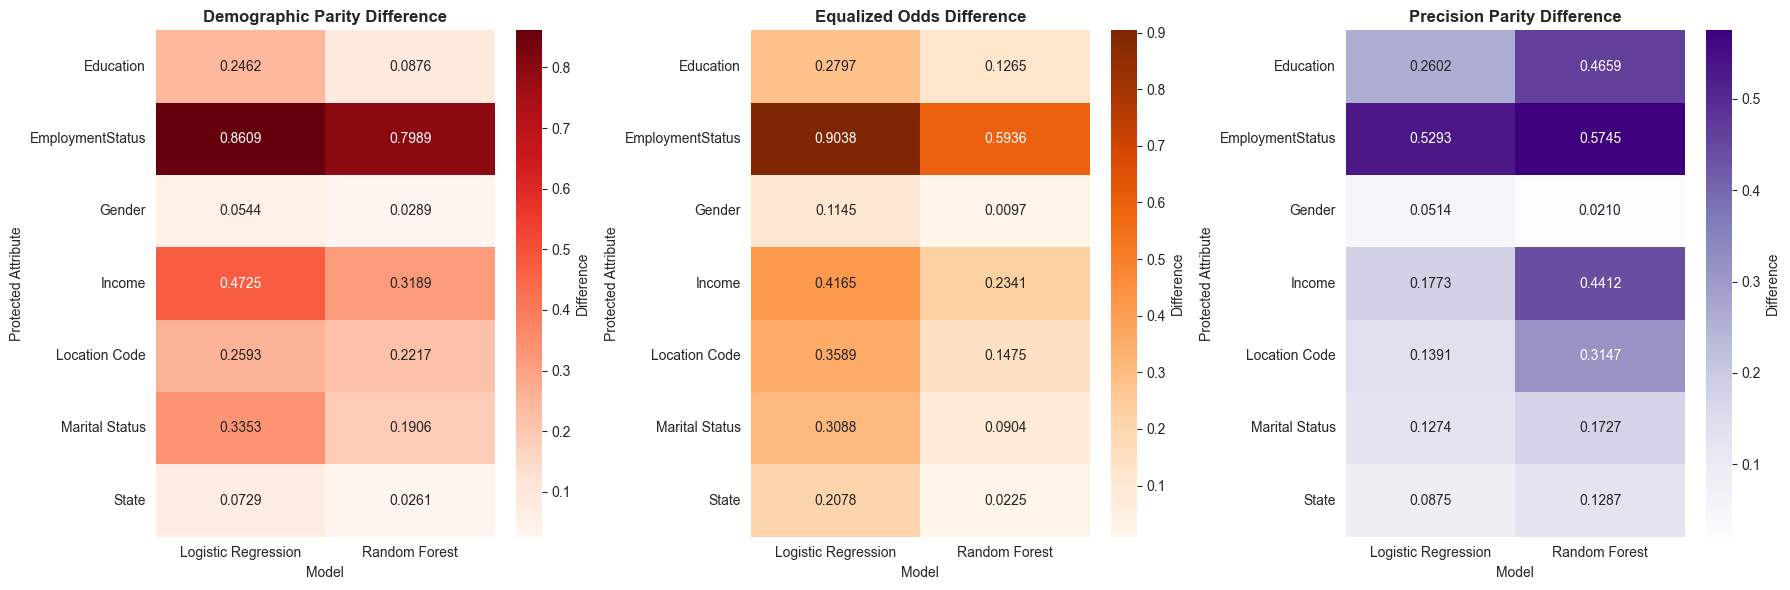


Key Findings:
   • Highest Demographic Parity Disparity: 0.8609
   • Highest Equalized Odds Disparity: 0.9038
   • Highest Precision Disparity: 0.5745


In [9]:
# Create comprehensive summary table
summary_rows = []

for model_name in all_fairness_results:
    for attr_name in all_fairness_results[model_name]:
        metrics = all_fairness_results[model_name][attr_name]
        summary_rows.append({
            'Model': model_name,
            'Protected Attribute': attr_name,
            'Demographic Parity Diff': metrics['demographic_parity_difference'],
            'Equalized Odds Diff': metrics['equalized_odds_difference'],
            'Precision Diff': metrics['precision_difference'],
            'TPR Diff': metrics['tpr_difference'],
            'FPR Diff': metrics['fpr_difference']
        })

summary_df = pd.DataFrame(summary_rows)

print("=" * 80)
print("FAIRNESS METRICS SUMMARY")
print("=" * 80)
print("\nAll differences are absolute differences between groups.")
print("Lower values indicate better fairness.\n")
print(summary_df.round(4).to_string())

# Create heatmap of fairness disparities
# Check if we have enough data for heatmaps
num_models = summary_df['Model'].nunique()
num_attributes = summary_df['Protected Attribute'].nunique()

if num_models >= 2 and num_attributes >= 2:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Pivot tables for heatmaps
    dp_pivot = summary_df.pivot(index='Protected Attribute', columns='Model', values='Demographic Parity Diff')
    eo_pivot = summary_df.pivot(index='Protected Attribute', columns='Model', values='Equalized Odds Diff')
    prec_pivot = summary_df.pivot(index='Protected Attribute', columns='Model', values='Precision Diff')
    
    # Demographic Parity Heatmap
    sns.heatmap(dp_pivot, annot=True, fmt='.4f', cmap='Reds', ax=axes[0], cbar_kws={'label': 'Difference'})
    axes[0].set_title('Demographic Parity Difference', fontsize=12, fontweight='bold')
    
    # Equalized Odds Heatmap
    sns.heatmap(eo_pivot, annot=True, fmt='.4f', cmap='Oranges', ax=axes[1], cbar_kws={'label': 'Difference'})
    axes[1].set_title('Equalized Odds Difference', fontsize=12, fontweight='bold')
    
    # Precision Parity Heatmap
    sns.heatmap(prec_pivot, annot=True, fmt='.4f', cmap='Purples', ax=axes[2], cbar_kws={'label': 'Difference'})
    axes[2].set_title('Precision Parity Difference', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Cannot create heatmaps: Need at least 2 models and 2 attributes")
    print(f"   Current: {num_models} model(s), {num_attributes} attribute(s)")
    print("   Displaying summary table instead (see above)")

print("\nKey Findings:")
# Handle NaN values in summary statistics
dp_max = summary_df['Demographic Parity Diff'].max()
eo_max = summary_df['Equalized Odds Diff'].max()
prec_max = summary_df['Precision Diff'].max()

print(f"   • Highest Demographic Parity Disparity: {dp_max:.4f}" if not pd.isna(dp_max) else "   • Highest Demographic Parity Disparity: N/A (NaN values present)")
print(f"   • Highest Equalized Odds Disparity: {eo_max:.4f}" if not pd.isna(eo_max) else "   • Highest Equalized Odds Disparity: N/A (NaN values present)")
print(f"   • Highest Precision Disparity: {prec_max:.4f}" if not pd.isna(prec_max) else "   • Highest Precision Disparity: N/A (NaN values present)")


## 5. Save Fairness Analysis Results

Save all fairness metrics for downstream comparison with mitigated models.


In [10]:
# Prepare results for saving (convert to JSON-serializable format)
fairness_results_serializable = {}

for model_name in all_fairness_results:
    fairness_results_serializable[model_name] = {}
    for attr_name in all_fairness_results[model_name]:
        metrics = all_fairness_results[model_name][attr_name]
        
        # Convert by_group DataFrame to dict
        by_group_dict = metrics['by_group'].to_dict('index')
        
        # Handle NaN values in serialization (convert to None for JSON compatibility)
        def safe_float(value):
            """Convert value to float, or None if NaN."""
            try:
                if pd.isna(value) or np.isnan(value):
                    return None
                return float(value)
            except (TypeError, ValueError):
                return None
        
        fairness_results_serializable[model_name][attr_name] = {
            'demographic_parity_difference': safe_float(metrics['demographic_parity_difference']),
            'demographic_parity_ratio': safe_float(metrics['demographic_parity_ratio']),
            'equalized_odds_difference': safe_float(metrics['equalized_odds_difference']),
            'equalized_odds_ratio': safe_float(metrics['equalized_odds_ratio']),
            'precision_difference': safe_float(metrics['precision_difference']),
            'precision_ratio': safe_float(metrics['precision_ratio']),
            'tpr_difference': safe_float(metrics['tpr_difference']),
            'fpr_difference': safe_float(metrics['fpr_difference']),
            'by_group': by_group_dict,
            'selection_by_group': {str(k): float(v) for k, v in metrics['selection_by_group'].items()},
            'tpr_by_group': {str(k): float(v) for k, v in metrics['tpr_by_group'].items()},
            'fpr_by_group': {str(k): float(v) for k, v in metrics['fpr_by_group'].items()},
            'precision_by_group': {str(k): float(v) for k, v in metrics['precision_by_group'].items()},
            'group_sizes': {str(k): int(v) for k, v in metrics.get('group_sizes', {}).items()}
        }

# Save to JSON
with open(results_dir / 'baseline_fairness_analysis.json', 'w') as f:
    json.dump(fairness_results_serializable, f, indent=2)

# Save summary table as CSV
summary_df.to_csv(results_dir / 'baseline_fairness_summary.csv', index=False)

print("Fairness analysis results saved!")
print(f"   • baseline_fairness_analysis.json")
print(f"   • baseline_fairness_summary.csv")
print(f"\n   Saved to: {results_dir.absolute()}")

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE!")
print("=" * 60)
print("Next steps:")
print("  Proceed to notebook 04_mitigation.ipynb")
print("  Apply fairness-aware techniques to reduce identified disparities")


Fairness analysis results saved!
   • baseline_fairness_analysis.json
   • baseline_fairness_summary.csv

   Saved to: c:\Users\Anthony Stills Jr\Documents\CS Projects\insurance-fairness\notebooks\..\results

NOTEBOOK COMPLETE!
Next steps:
  Proceed to notebook 04_mitigation.ipynb
  Apply fairness-aware techniques to reduce identified disparities
